In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

pd.set_option("display.max_columns",30)

In [135]:
barbados_processed_df = pd.read_csv("station_data_processed/barbados_hourly_processed_data.csv", index_col=0)
barbados_processed_df.index = pd.to_datetime(barbados_processed_df.index, errors='coerce')



In [136]:
barbados_processed_df.describe()

bmp180_temp  bmp180_pres  bmp180_slp  bmp180_alt   bmp280_temp  \
count          0.0          0.0         0.0         0.0  1.395374e+06   
mean           NaN          NaN         NaN         NaN  2.598573e+01   
std            NaN          NaN         NaN         NaN  2.036694e+00   
min            NaN          NaN         NaN         NaN -3.918000e+01   
25%            NaN          NaN         NaN         NaN  2.455000e+01   
50%            NaN          NaN         NaN         NaN  2.568000e+01   
75%            NaN          NaN         NaN         NaN  2.726000e+01   
max            NaN          NaN         NaN         NaN  4.268000e+01   

        bmp280_pres    bmp280_slp  bmp280_alt  bme_temp  bme_pres  bme_slp  \
count  1.395378e+06  1.395368e+06   1395392.0       0.0       0.0      0.0   
mean   9.332898e+02  9.628658e+02       274.0       NaN       NaN      NaN   
std    1.147523e+02  1.183235e+02         0.0       NaN       NaN      NaN   
min    3.107400e+02  3.206700e+02       274.0       NaN       NaN      NaN   
25%    9.826200e+02  1.013680e+03       274.0       NaN       NaN      NaN   
50%    9.845700e+02  1.015760e+03       274.0       NaN       NaN      NaN   
75%    9.858800e+02  1.017110e+03       274.0       NaN       NaN      NaN   
max    1.084970e+03  1.119660e+03       274.0       NaN       NaN      NaN   

       bme_alt  bme_hum      htu_temp        htu_hum       mcp9808  \
count      0.0      0.0  1.426764e+06  943240.000000  1.311516e+06   
mean       NaN      NaN  2.256297e+01      86.010551  2.478773e+01   
std        NaN      NaN  5.692327e+00       8.425503  4.263707e+00   
min        NaN      NaN -2.650000e+01      46.500000 -3.840000e+01   
25%        NaN      NaN  2.250000e+01      80.100000  2.390000e+01   
50%        NaN      NaN  2.440000e+01      87.000000  2.510000e+01   
75%        NaN      NaN  2.580000e+01      92.700000  2.660000e+01   
max        NaN      NaN  4.500000e+01      99.900000  4.490000e+01   

            tipping     vis_light      ir_light      uv_light  wind_dir  \
count  1.738321e+06  1.396726e+06  1.396757e+06  1.394328e+06  431477.0   
mean   3.238297e-03  4.199162e+02  1.936871e+03  8.883705e+01       0.0   
std    5.012715e-02  2.490730e+02  2.568407e+03  1.316282e+02       0.0   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00       0.0   
25%    0.000000e+00  2.600000e+02  2.530000e+02  2.000000e+00       0.0   
50%    0.000000e+00  2.680000e+02  3.220000e+02  5.000000e+00       0.0   
75%    0.000000e+00  5.080000e+02  2.806000e+03  1.350000e+02       0.0   
max    1.260000e+01  1.960000e+03  1.405200e+04  9.840000e+02       0.0   

         wind_speed  
count  1.736274e+06  
mean   2.856802e+00  
std    3.909653e+00  
min    0.000000e+00  
25%    1.500000e+00  
50%    2.640000e+00  
75%    3.710000e+00  
max    9.998000e+01

# Statistic

In [137]:
def statistics(df, hourly = False): 
    # turn objec index into datetime index
    df.index = pd.to_datetime(df.index)

    df = df.sort_index()

    if hourly:
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # min stands for minute frequency
        time_unit  = "hour"
    else:
        # Create a complete minute-wise index
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')  # min stands for minute frequency
        time_unit  = "minute"
    
    # Reindex the dataframe to include all minutes, filling missing with NaN
    df = df.reindex(full_index) 

    # Total timespan/steps
    total_time = full_index.shape[0]

    # Actual measurements not Nan
    actual_measurements = df.notna().sum()
    relative_measurements = actual_measurements / total_time * 100

    # Non - zero measurments 
    zero_measurements = (df == 0).sum()
    nan_count = df.isna().sum()
    
    non_zero_measurements = actual_measurements - zero_measurements
    relative_non_zero_measurements = non_zero_measurements / total_time * 100
    nonzerorelativetoactual = non_zero_measurements / actual_measurements * 100
    
    print(f"Total {time_unit}s: {total_time}")
    print(f"Total {time_unit}s: 100%")
    print(f"Actual measurements: {actual_measurements}")
    print(f"Relative measurements: {relative_measurements:.2f}%")
    print(f"Non-zero measurements: {non_zero_measurements}")
    print(f"Relative non-zero measurements: {relative_non_zero_measurements:.2f}%")
    print(f"Non-zero relative to actual: {nonzerorelativetoactual:.2f}%")
    print(f"Zero measurements: {zero_measurements}")
    print(f"NaN measurements: {nan_count}")

In [138]:
def plot_hist(df, var_name, station, save=False):

    staion_name = station
    # Create a histogram with log scale on the y-axis
    
    plt.figure(figsize=(14,6) )
    plt.hist(df[var_name], bins=50, log=False, color='mediumblue', edgecolor='black')     

    # Add labels and title
    plt.xlabel(f"{var_name.capitalize()} Bins")
    plt.ylabel("Count (Log Scale)")
    plt.title(f"{station.capitalize()}: Histogram of {var_name.capitalize()}")
    plt.grid(True)

    if save:
    # Check if the 'eda' directory exists, if not, create it
        save_dir = "eda"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        plt.savefig(f"eda/{staion_name}_{var_name}_hist.png")
        print(f"Figure saved as eda/{staion_name}_{var_name}_hist.png")

    # Display the plot
    plt.show()





In [139]:
summary = statistics(barbados_processed_df["mcp9808"])


Total minutes: 1817508
Total minutes: 100%
Actual measurements: 1311516
Relative measurements: 72.16%
Non-zero measurements: 1283370
Relative non-zero measurements: 70.61%
Non-zero relative to actual: 97.85%
Zero measurements: 28146
NaN measurements: 505992


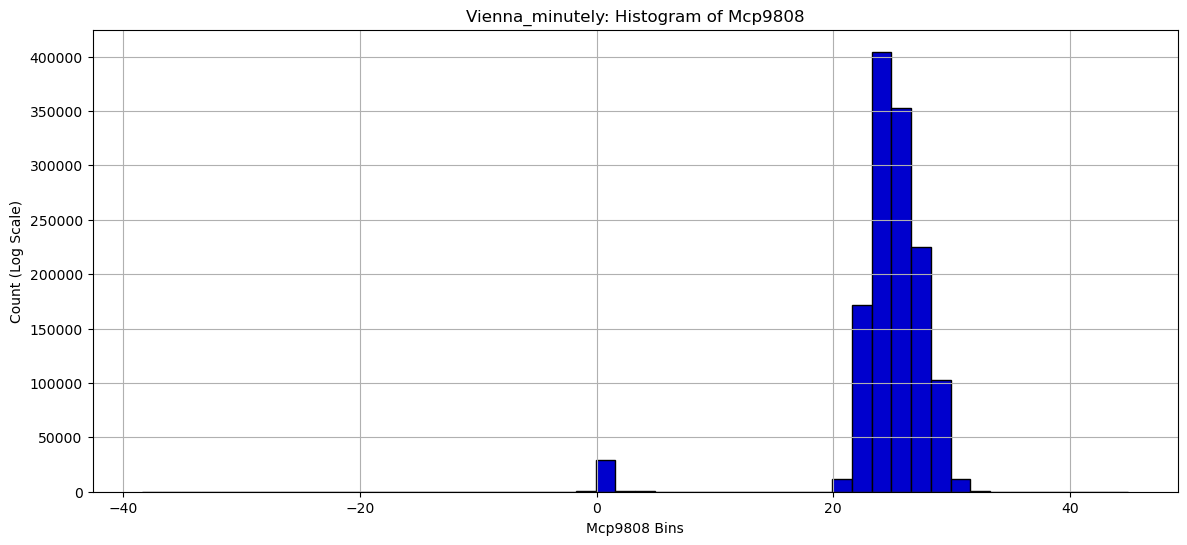

In [140]:
plot_hist(barbados_processed_df, "mcp9808", "vienna_minutely", save=False)

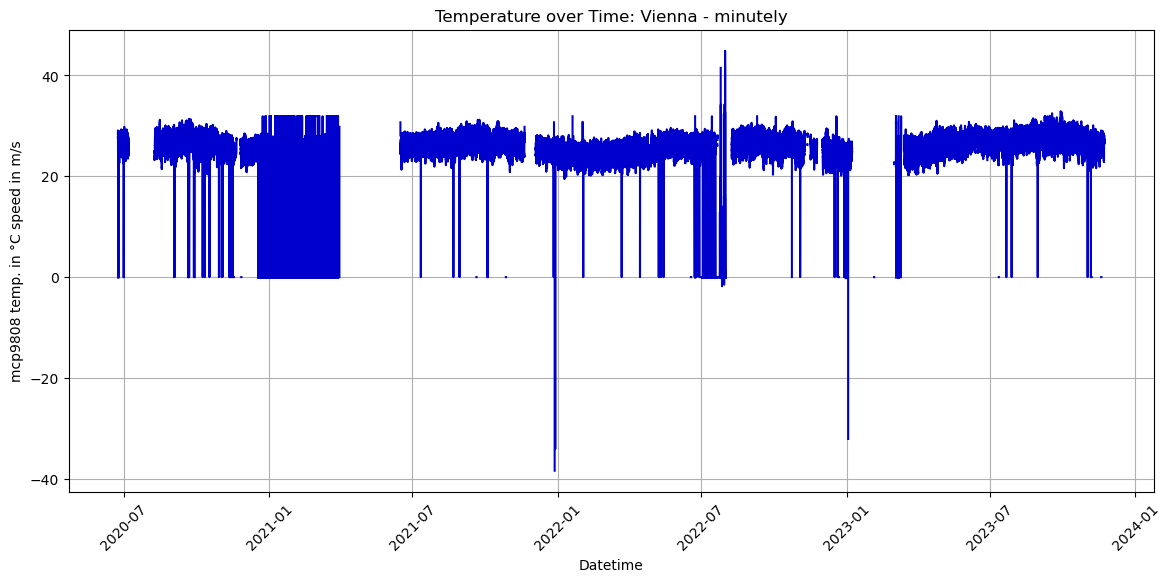

In [141]:
plt.figure(figsize=(14,6) )
plt.plot(barbados_processed_df["mcp9808"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("mcp9808 temp. in °C speed in m/s") 
plt.title("Temperature over Time: Vienna - minutely")
plt.xticks(rotation=45)
plt.grid(True)

# plt.savefig("eda/vienna_mcp9808_minutely_plot.png")

plt.show()

In [32]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_aggregation(var_name):
    """
    Define custom aggregation functions for different variables during resampling.
    """
    def aggregate(series):
        # Exclude if the series has too many missing values
        if series.isna().sum() > 20:
            return np.nan
        # Exclude if the series has fewer than 3 unique values (except for 'tipping')
        if var_name != 'tipping' and series.nunique() <= 3:
            return np.nan
        if var_name == "mcp9808": 
            series = series.replace(0.00, np.nan)

            

        if var_name == 'tipping':
            # Sum for precipitation
            return series.sum()
        elif var_name == 'wind_speed':
            # Mean for wind speed
            return series.mean()
        elif var_name == 'wind_dir':
            # Circular mean for wind direction
            return circular_mean(series)
        else:
            # Median for other variables
            return series.median()
    return aggregate

aggregation_dict = {'bmp180_temp': "mean",
                    'bmp180_pres': "mean",
                    'bmp180_slp': "mean",
                    'bmp180_alt': "mean",
                    'bmp280_temp': "mean",
                    'bmp280_pres': "mean",
                    'bmp280_slp': "mean",
                    'bmp280_alt': "mean",
                    'bme_temp': "mean",
                    'bme_pres': "mean",
                    'bme_slp': "mean",
                    'bme_alt': "mean",
                    'bme_hum': "mean",
                    'htu_temp': "mean",
                    'htu_hum': "mean",
                    'mcp9808': "mean",
                    'tipping': "sum",
                    'vis_light': "mean",
                    'ir_light': "mean",
                    'uv_light': "mean",
                    'wind_dir': "mean",
                    'wind_speed': "mean"}

In [143]:
hourly_df = pd.DataFrame()

for var_name in barbados_processed_df.columns:
    hourly_series = barbados_processed_df[var_name].resample('h').apply(custom_aggregation(var_name))
    hourly_df[var_name] = hourly_series

In [144]:
hourly_df

bmp180_temp  bmp180_pres  bmp180_slp  bmp180_alt  \
datetime                                                                
2020-06-08 15:00:00          NaN          NaN         NaN         NaN   
2020-06-08 16:00:00          NaN          NaN         NaN         NaN   
2020-06-08 17:00:00          NaN          NaN         NaN         NaN   
2020-06-08 18:00:00          NaN          NaN         NaN         NaN   
2020-06-08 19:00:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2023-11-22 15:00:00          NaN          NaN         NaN         NaN   
2023-11-22 16:00:00          NaN          NaN         NaN         NaN   
2023-11-22 17:00:00          NaN          NaN         NaN         NaN   
2023-11-22 18:00:00          NaN          NaN         NaN         NaN   
2023-11-22 19:00:00          NaN          NaN         NaN         NaN   

                     bmp280_temp  bmp280_pres  bmp280_slp  bmp280_alt  \
datetime                                                                
2020-06-08 15:00:00          NaN          NaN         NaN         NaN   
2020-06-08 16:00:00          NaN          NaN         NaN         NaN   
2020-06-08 17:00:00          NaN          NaN         NaN         NaN   
2020-06-08 18:00:00          NaN          NaN         NaN         NaN   
2020-06-08 19:00:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2023-11-22 15:00:00        28.66      982.875    1013.750         NaN   
2023-11-22 16:00:00        29.05      982.170    1012.980         NaN   
2023-11-22 17:00:00        28.84      981.645    1012.470         NaN   
2023-11-22 18:00:00        28.37      981.230    1012.085         NaN   
2023-11-22 19:00:00        28.48      981.090    1011.920         NaN   

                     bme_temp  bme_pres  bme_slp  bme_alt  bme_hum  htu_temp  \
datetime                                                                       
2020-06-08 15:00:00       NaN       NaN      NaN      NaN      NaN       NaN   
2020-06-08 16:00:00       NaN       NaN      NaN      NaN      NaN       NaN   
2020-06-08 17:00:00       NaN       NaN      NaN      NaN      NaN       NaN   
2020-06-08 18:00:00       NaN       NaN      NaN      NaN      NaN       NaN   
2020-06-08 19:00:00       NaN       NaN      NaN      NaN      NaN       NaN   
...                       ...       ...      ...      ...      ...       ...   
2023-11-22 15:00:00       NaN       NaN      NaN      NaN      NaN      10.4   
2023-11-22 16:00:00       NaN       NaN      NaN      NaN      NaN      11.6   
2023-11-22 17:00:00       NaN       NaN      NaN      NaN      NaN      11.7   
2023-11-22 18:00:00       NaN       NaN      NaN      NaN      NaN      11.6   
2023-11-22 19:00:00       NaN       NaN      NaN      NaN      NaN      11.5   

                     htu_hum  mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                                        
2020-06-08 15:00:00      NaN      NaN      0.0        NaN       NaN       NaN   
2020-06-08 16:00:00      NaN      NaN      0.0        NaN       NaN       NaN   
2020-06-08 17:00:00      NaN      NaN      0.0        NaN       NaN       NaN   
2020-06-08 18:00:00      NaN      NaN      0.0        NaN       NaN       NaN   
2020-06-08 19:00:00      NaN      NaN      NaN        NaN       NaN       NaN   
...                      ...      ...      ...        ...       ...       ...   
2023-11-22 15:00:00      NaN    27.30      0.0      845.0    6304.5     315.0   
2023-11-22 16:00:00      NaN    27.60      0.0      923.0    7158.5     356.5   
2023-11-22 17:00:00      NaN    27.40      0.0      730.0    5044.5     253.5   
2023-11-22 18:00:00      NaN    26.95      0.0      589.0    3605.0     178.0   
2023-11-22 19:00:00      NaN    27.00      0.0      554.0    3272.0     159.0   

                     wind_

In [145]:
summary = statistics(hourly_df["mcp9808"], hourly=True)


Total hours: 30293
Total hours: 100%
Actual measurements: 17389
Relative measurements: 57.40%
Non-zero measurements: 17389
Relative non-zero measurements: 57.40%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 12904


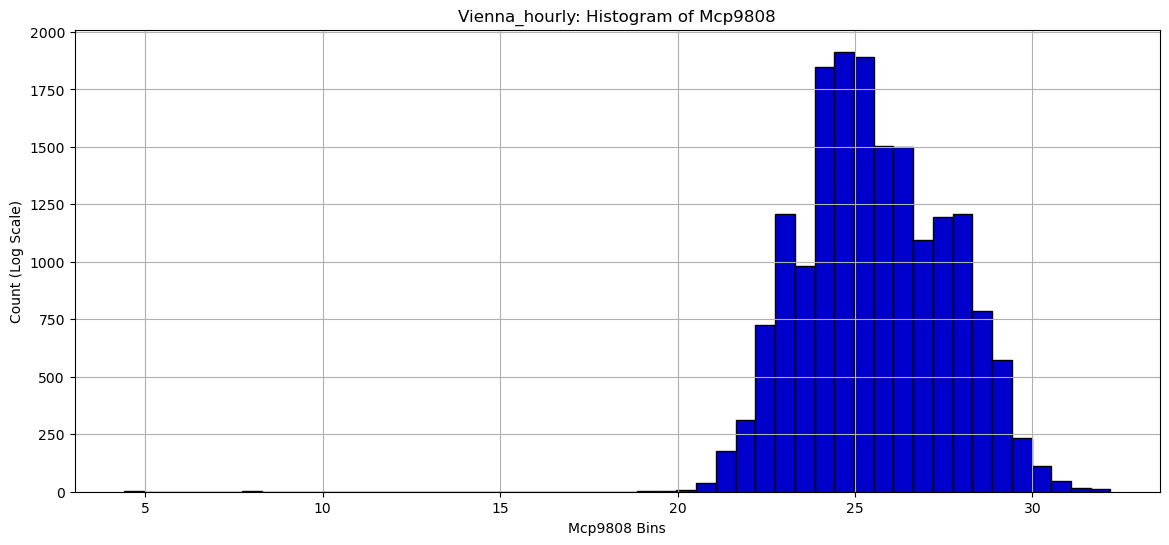

In [146]:
plot_hist(hourly_df, "mcp9808", "Vienna_hourly", save=False)


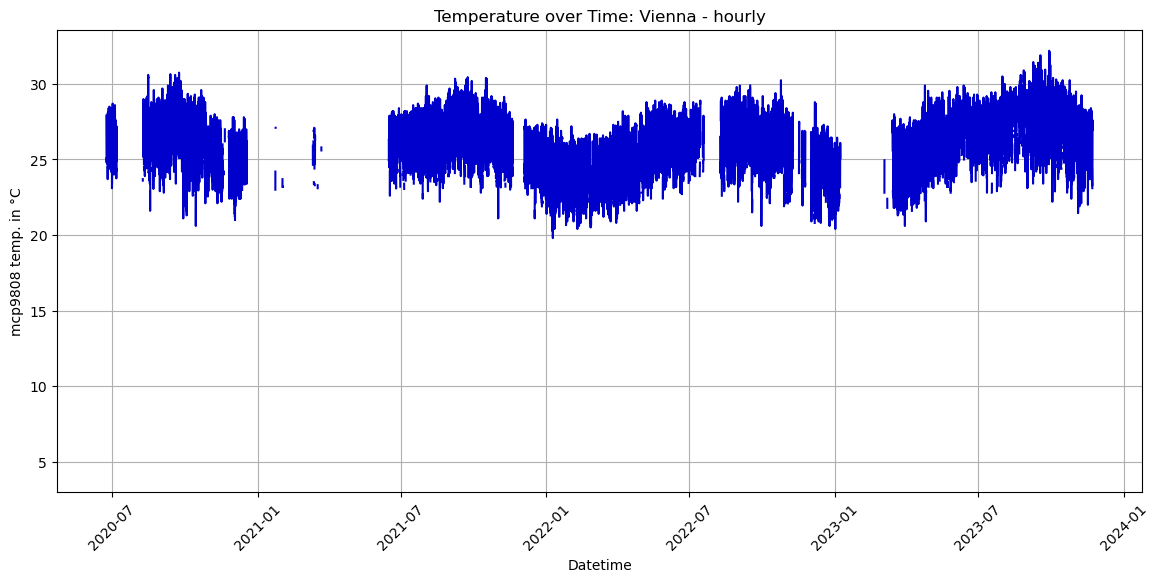

In [147]:
plt.figure(figsize=(14,6) )
plt.plot(hourly_df["mcp9808"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("mcp9808 temp. in °C")
plt.title("Temperature over Time: Vienna - hourly")
plt.xticks(rotation=45)
plt.grid(True)

# plt.savefig("eda/Vienna_mcp9808_hourly_plot.png")

plt.show()

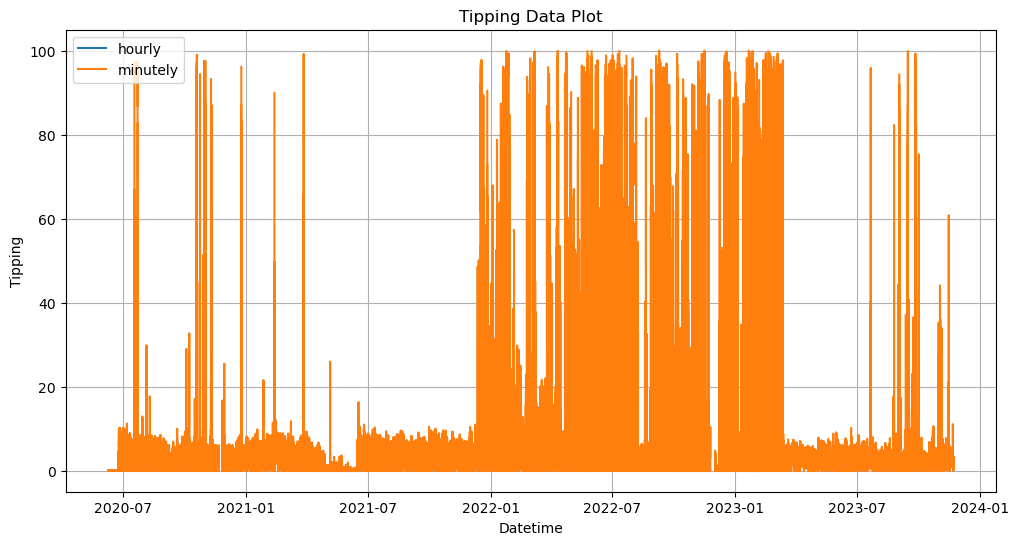

In [517]:
plt.figure(figsize=(12,6) )
plt.plot(hourly_df["wind_speed"], label="hourly")


plt.plot(barbados_processed_df["wind_speed"], label="minutely")

plt.xlabel("Datetime")
plt.ylabel("Tipping")
plt.title("Tipping Data Plot")
plt.legend()
plt.grid(True)




plt.show()

# Event

In [2]:
marhsall_processed_df = pd.read_csv("station_data_processed/marshall_hourly_processed_data.csv", index_col=0)
marhsall_processed_df.index = pd.to_datetime(marhsall_processed_df.index, errors='coerce')

In [3]:
marhsall_processed_df

bmp180_temp  bmp180_pres  bmp180_slp  bmp180_alt  \
datetime                                                                
2017-03-01 05:24:00          NaN          NaN         NaN         NaN   
2017-03-01 05:25:00          NaN          NaN         NaN         NaN   
2017-03-01 05:26:00          NaN          NaN         NaN         NaN   
2017-03-01 05:27:00          NaN          NaN         NaN         NaN   
2017-03-01 05:28:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2023-11-29 19:52:00         12.7       818.18     1003.67      1743.0   
2023-11-29 19:53:00         12.7       818.20     1003.69      1743.0   
2023-11-29 19:54:00         12.7       814.06      998.61      1743.0   
2023-11-29 19:55:00         13.0       818.23     1003.52      1743.0   
2023-11-29 19:56:00          NaN          NaN         NaN         NaN   

                     bmp280_temp  bmp280_pres  bmp280_slp  bmp280_alt  \
datetime                                                                
2017-03-01 05:24:00          NaN          NaN         NaN         NaN   
2017-03-01 05:25:00          NaN          NaN         NaN         NaN   
2017-03-01 05:26:00          NaN          NaN         NaN         NaN   
2017-03-01 05:27:00          NaN          NaN         NaN         NaN   
2017-03-01 05:28:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2023-11-29 19:52:00          NaN          NaN         NaN         NaN   
2023-11-29 19:53:00          NaN          NaN         NaN         NaN   
2023-11-29 19:54:00          NaN          NaN         NaN         NaN   
2023-11-29 19:55:00          NaN          NaN         NaN         NaN   
2023-11-29 19:56:00          NaN          NaN         NaN         NaN   

                     bme_temp  bme_pres  bme_slp  bme_alt  bme_hum  htu_temp  \
datetime                                                                       
2017-03-01 05:24:00       NaN       NaN      NaN      NaN      NaN       NaN   
2017-03-01 05:25:00       NaN       NaN      NaN      NaN      NaN       NaN   
2017-03-01 05:26:00       NaN       NaN      NaN      NaN      NaN       NaN   
2017-03-01 05:27:00       NaN       NaN      NaN      NaN      NaN       NaN   
2017-03-01 05:28:00       NaN       NaN      NaN      NaN      NaN       NaN   
...                       ...       ...      ...      ...      ...       ...   
2023-11-29 19:52:00       NaN       NaN      NaN      NaN      NaN      12.4   
2023-11-29 19:53:00       NaN       NaN      NaN      NaN      NaN      12.4   
2023-11-29 19:54:00       NaN       NaN      NaN      NaN      NaN      12.5   
2023-11-29 19:55:00       NaN       NaN      NaN      NaN      NaN      12.8   
2023-11-29 19:56:00       NaN       NaN      NaN      NaN      NaN       NaN   

                     htu_hum  mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                                        
2017-03-01 05:24:00      NaN      NaN      0.0        NaN       NaN       NaN   
2017-03-01 05:25:00      NaN      NaN      0.0        NaN       NaN       NaN   
2017-03-01 05:26:00      NaN      NaN      0.0        NaN       NaN       NaN   
2017-03-01 05:27:00      NaN      NaN      0.0        NaN       NaN       NaN   
2017-03-01 05:28:00      NaN      NaN      0.0        NaN       NaN       NaN   
...                      ...      ...      ...        ...       ...       ...   
2023-11-29 19:52:00      NaN      NaN      0.0        NaN       NaN       NaN   
2023-11-29 19:53:00      NaN      NaN      0.0        NaN       NaN       NaN   
2023-11-29 19:54:00      NaN      NaN      0.0        NaN       NaN       NaN   
2023-11-29 19:55:00      NaN      NaN      0.0        NaN       NaN       NaN   
2023-11-29 19:56:00      NaN      NaN      NaN        NaN       NaN       NaN   

                     wind_

In [4]:
marshall_hourly_df = pd.DataFrame()

for var_name in marhsall_processed_df.columns:
    hourly_series = marhsall_processed_df[var_name].resample('h').apply(custom_aggregation(var_name))
    marshall_hourly_df[var_name] = hourly_series

NameError: name 'custom_aggregation' is not defined

In [ ]:
marshall_hourly_df.sort_values(by=['tipping'], ascending=False).head()


bmp180_temp  bmp180_pres  bmp180_slp  bmp180_alt  \
datetime                                                                
2020-02-08 16:00:00        -1.05      815.910    1011.030         NaN   
2020-02-08 17:00:00         1.15      815.400    1008.590         NaN   
2021-02-19 17:00:00          NaN          NaN         NaN         NaN   
2020-04-03 19:00:00         0.70      824.600    1020.465         NaN   
2018-04-13 16:00:00         4.40      814.985    1005.685         NaN   

                     bmp280_temp  bmp280_pres  bmp280_slp  bmp280_alt  \
datetime                                                                
2020-02-08 16:00:00          NaN          NaN         NaN         NaN   
2020-02-08 17:00:00          NaN          NaN         NaN         NaN   
2021-02-19 17:00:00          NaN          NaN         NaN         NaN   
2020-04-03 19:00:00          NaN          NaN         NaN         NaN   
2018-04-13 16:00:00          NaN          NaN         NaN         NaN   

                     bme_temp  bme_pres  bme_slp  bme_alt  bme_hum  htu_temp  \
datetime                                                                       
2020-02-08 16:00:00       NaN       NaN      NaN      NaN      NaN     -1.00   
2020-02-08 17:00:00       NaN       NaN      NaN      NaN      NaN      1.15   
2021-02-19 17:00:00       NaN       NaN      NaN      NaN      NaN      2.25   
2020-04-03 19:00:00       NaN       NaN      NaN      NaN      NaN      1.10   
2018-04-13 16:00:00       NaN       NaN      NaN      NaN      NaN      5.00   

                     htu_hum  mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                                        
2020-02-08 16:00:00    73.50     -0.4    468.0      549.5    3265.5     157.0   
2020-02-08 17:00:00    68.40      1.9    105.8      665.5    4472.5     219.0   
2021-02-19 17:00:00    40.65      2.6     60.2        NaN       NaN       NaN   
2020-04-03 19:00:00    70.70      1.0     60.2        NaN       NaN       NaN   
2018-04-13 16:00:00    43.00      5.1     37.6        NaN       NaN       NaN   

                       wind_dir  wind_speed  
datetime                                     
2020-02-08 16:00:00  138.968769    1.910175  
2020-02-08 17:00:00    1.411853    1.381053  
2021-02-19 17:00:00  271.946125         NaN  
2020-04-03 19:00:00   48.420521    1.811053  
2018-04-13 16:00:00         NaN    1.296552

In [5]:
event_1 = pd.Timestamp("2020-02-08 16:00")

# measured 468 l/m2 in 1 h and the following hour measured 105 l/m2
# utc in local time 10:00

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df = marshall_hourly_df[(marshall_hourly_df.index >= event_1 - time_delta) & (marshall_hourly_df.index <= event_1 + time_delta)]
filtered_minute_df = marhsall_processed_df[(marhsall_processed_df.index >= event_1 - time_delta) & (marhsall_processed_df.index <= event_1 + time_delta)]

# View the filtered DataFrame
filtered_df


TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'Timestamp'

NameError: name 'filtered_df' is not defined

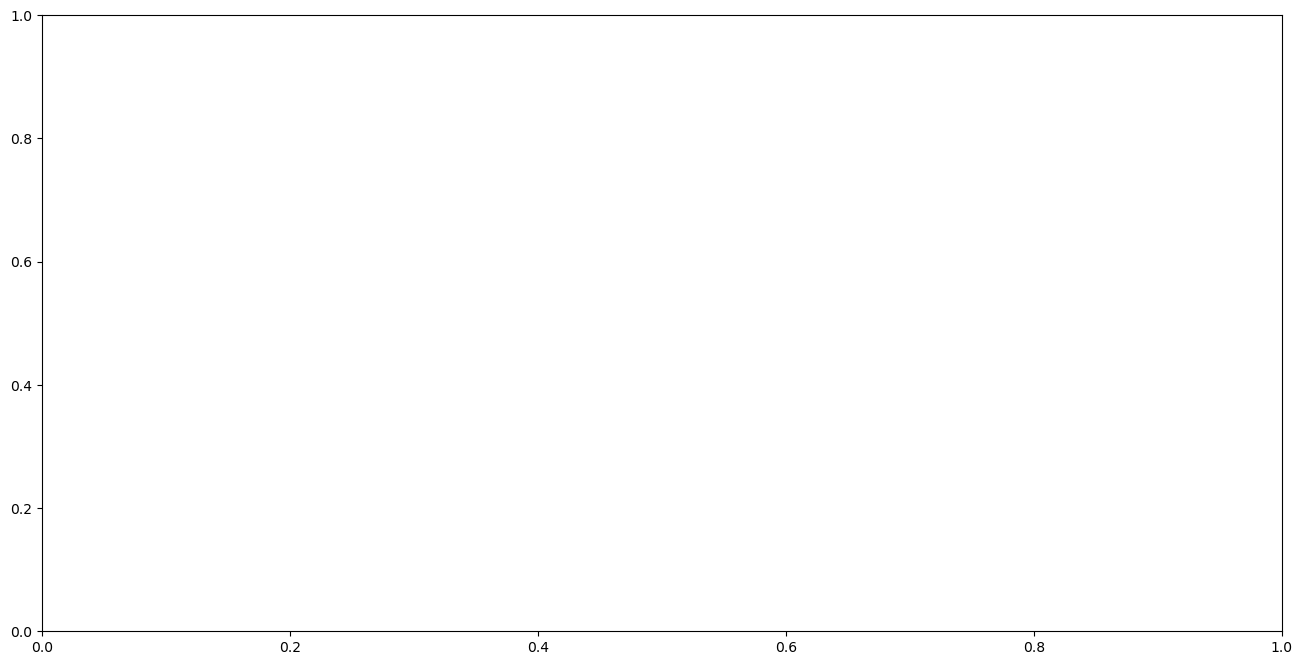

In [6]:
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df["tipping"], color='mediumblue', label="Hourly Tipping")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_minute_df["tipping"], color='orange', label="Minute Tipping")
ax2.set_ylabel("Tipping in mm (Minute)")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()


NameError: name 'filtered_df' is not defined

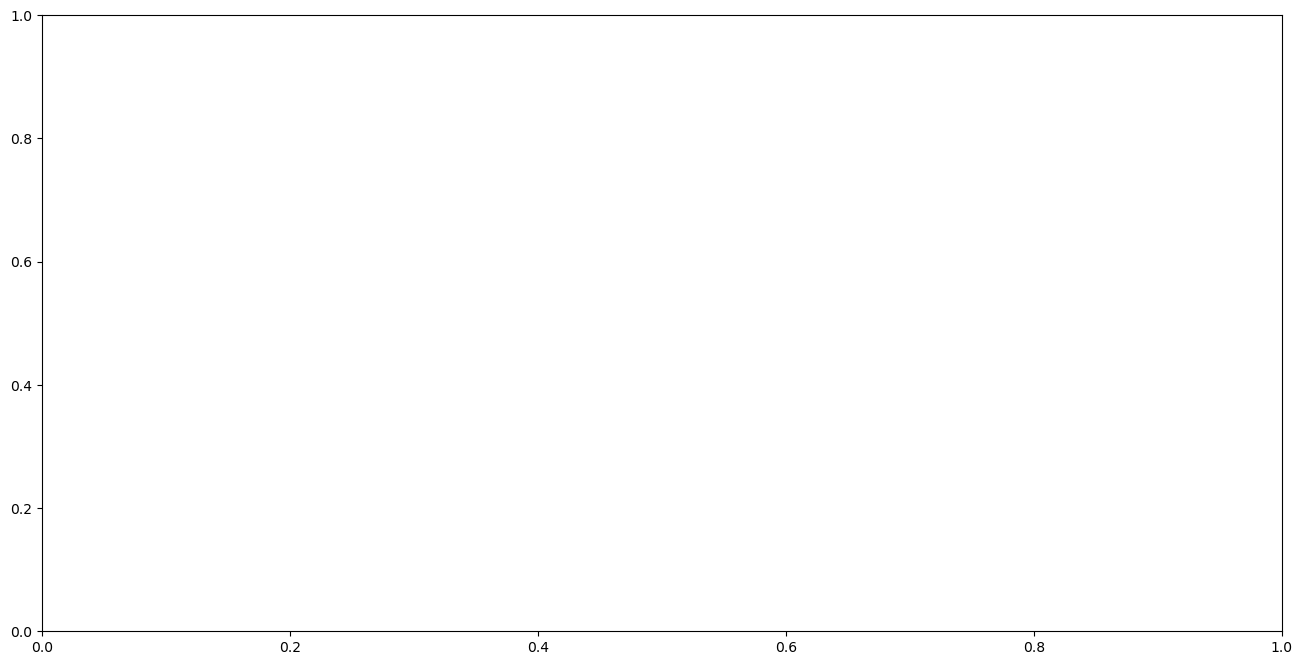

In [7]:
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df["mcp9808"], color='mediumblue', label="Hourly Temperature")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Temp. in °C ")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_minute_df["tipping"], color='orange', label="Minute Tipping")
ax2.set_ylabel("Tipping in mm (Minute)")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()

### ERA5 Data

Extracting Marshall...


100%|██████████| 2465/2465 [01:42<00:00, 24.09it/s]


displaying lon: -105.196
as -105.196


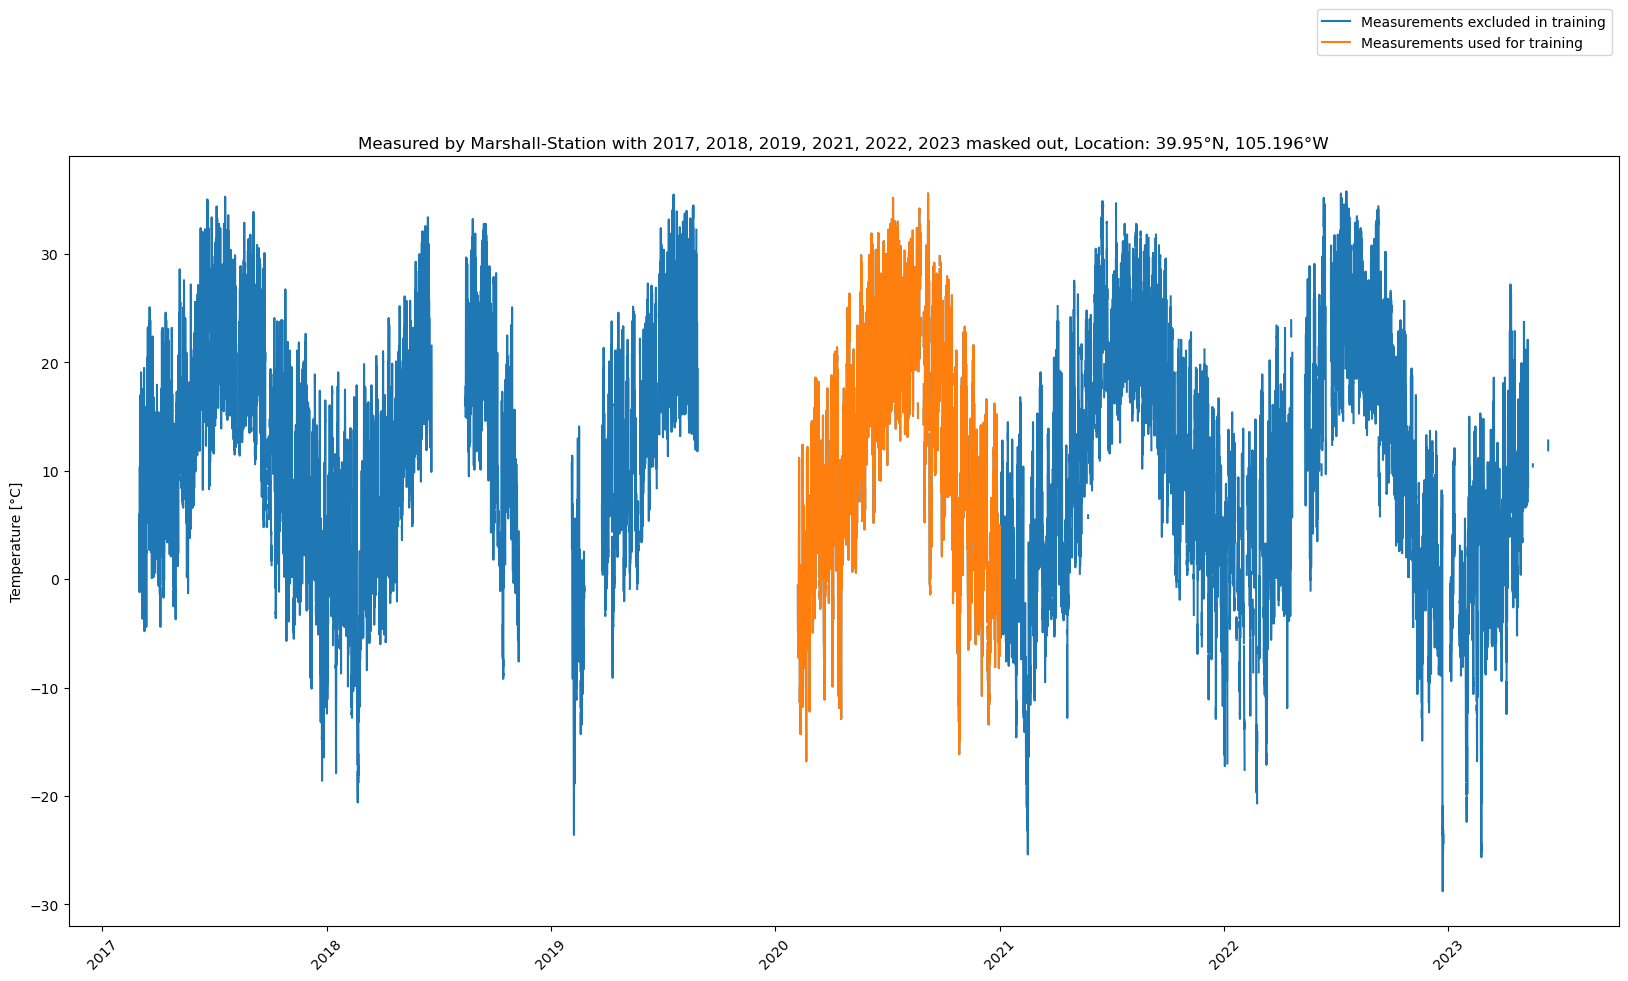

                        tas  vis_light  uv_light  ir_light
datetime                                                  
2020-02-07 00:00:00  272.55      262.0       3.0     264.5
2020-02-07 01:00:00  271.75      260.0       NaN     254.0
2020-02-07 02:00:00  271.00      261.0       NaN     253.0
2020-02-07 03:00:00  270.95      260.0       NaN     253.5
2020-02-07 04:00:00  268.35      260.5       NaN       NaN
Latitude: 39.9496, Longitude: -105.196
Missing hours: [Timestamp('2017-03-01 05:00:00'), Timestamp('2017-03-01 06:00:00'), Timestamp('2017-03-01 07:00:00'), Timestamp('2017-03-01 08:00:00'), Timestamp('2017-03-01 09:00:00'), Timestamp('2017-03-01 10:00:00'), Timestamp('2017-03-01 11:00:00'), Timestamp('2017-03-01 12:00:00'), Timestamp('2017-03-01 13:00:00'), Timestamp('2017-03-01 14:00:00'), Timestamp('2017-03-01 15:00:00'), Timestamp('2017-03-01 16:00:00'), Timestamp('2017-03-01 17:00:00'), Timestamp('2017-03-01 18:00:00'), Timestamp('2017-03-01 19:00:00'), Timestamp('2017-03-01 

In [192]:
# Import necessary classes
from station.station import StationData

# Define your station name and data folder path
station_name = 'Marshall'
data_folder_path = 'measurements/Marshall'

# Optional parameters
mask_years = [2017,2018,2019,2021,2022,2023]  # Exclude data from these years
first_n_files = None  # Process all files
progress = None  # No progress tracking

# Create the StationData instance
station = StationData(
    name=station_name,
    folder_path=data_folder_path,
    mask_years=mask_years,
    first_n_files=first_n_files,
    progress=progress
)

# Access the processed data
data_df = station.df
print(data_df.head())

# Access metadata
metadata = station.metadata
print(f"Latitude: {metadata.get('latitude')}, Longitude: {metadata.get('longitude')}")

# Find missing data gaps
missing_hours = station.find_gaps()
print(f"Missing hours: {missing_hours}")

# Get months present in the data
months_in_data = station.get_all_months_in_df()
print(f"Months in data: {months_in_data}")




In [193]:
from era5.era5_download_hook import Era5DownloadHook

#Marshall
hook = Era5DownloadHook(lat=39.9496, lon=-105.196)

from era5.era5_for_station import DownloadEra5ForStation

grib_dir_path = 'path/to/save/grib/files'
downloader = DownloadEra5ForStation(station=station, grib_dir_path=grib_dir_path, hook=hook)

Using URL: https://cds-beta.climate.copernicus.eu/api


In [195]:
import cdsapi

def download_era5_data(
    latitude,
    longitude,
    start_date,
    end_date,
    variables,
    area_size,
    output_filename,
    time_selection=None,
    product_type='reanalysis',
    dataset='reanalysis-era5-single-levels',
    format='netcdf',
):
    """
    Downloads ERA5 data for specific location, period, variables, and cropping area.

    Parameters:
    - latitude (float): Central latitude of the area.
    - longitude (float): Central longitude of the area.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - variables (list): List of variables to download.
    - area_size (float): Size of the area around the point in degrees.
    - output_filename (str): Path to save the output file.
    - time_selection (list, optional): List of times in 'HH:MM' format to include.
    - product_type (str): Type of product to download (default is 'reanalysis').
    - dataset (str): Dataset name (default is 'reanalysis-era5-single-levels').
    - format (str): Output file format (default is 'netcdf').

    Returns:
    - None
    """
    c = cdsapi.Client()

    # Define the area to download (north, west, south, east)
    half_size = area_size / 2
    area = [
        latitude + half_size,                # North
        longitude - half_size,               # West
        latitude - half_size,                # South
        longitude + half_size,               # East
    ]

    # Prepare the request parameters
    request = {
        'product_type': product_type,
        'format': format,
        'variable': variables,
        'area': area,
        'date': f'{start_date}/{end_date}',
    }

    # If specific times are provided, include them
    if time_selection:
        request['time'] = time_selection
    else:
        # Default to all hours
        request['time'] = [f'{hour:02d}:00' for hour in range(24)]

    # Retrieve the data
    print("Submitting request to CDS API...")
    c.retrieve(dataset, request, output_filename)
    print(f"Data downloaded successfully and saved to {output_filename}")




In [196]:
# Example usage,

if __name__ == "__main__":
    # Define parameters
    latitude = 39.9496      # Example: Latitude for Berlin
    longitude = -105.196     # Example: Longitude for Berlin
    start_date = '2020-02-07'
    end_date = '2020-02-09'
    variables = [
        'total_precipitation'
    ]
    area_size = 2.0          # 1-degree square around the point
    output_filename = 'era5_marshall_event1.nc'

# tp includes snow and rain, liquid and frozen

    # Download data
    download_era5_data(
        latitude,
        longitude,
        start_date,
        end_date,
        variables,
        area_size,
        output_filename,
    )

Submitting request to CDS API...


2024-10-08 16:30:53,527 INFO Request ID is 8d241539-75ee-4fa3-aae3-acc8b4931dcc
2024-10-08 16:30:53,628 INFO status has been updated to accepted
2024-10-08 16:32:46,965 INFO status has been updated to successful


af5f28fc78681aafc87aa12f1c26737.nc:   0%|          | 0.00/38.7k [00:00<?, ?B/s]

Data downloaded successfully and saved to era5_marshall_event1.nc


In [67]:
import xarray as xr
import numpy as np

class DatasetCropper:
    def __init__(self, dataset_path, output_path, station_lat, station_lon):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.station_lat = station_lat
        self.station_lon = station_lon

    def execute(self):
        self.crop_dataset()

    def crop_dataset(self):
        ds = xr.open_dataset(self.dataset_path)
        
        # Adjust coordinate names if necessary
        lat_name = 'latitude' if 'latitude' in ds.coords else 'lat'
        lon_name = 'longitude' if 'longitude' in ds.coords else 'lon'

        # Handle longitude wrapping
        if ds[lon_name].max() > 180:
            station_lon = self.station_lon % 360
        else:
            station_lon = self.station_lon

        # Find the index of the nearest grid point to the station coordinates
        abs_lat_diff = np.abs(ds[lat_name] - self.station_lat)
        abs_lon_diff = np.abs(ds[lon_name] - station_lon)
        min_lat_idx = abs_lat_diff.argmin().values
        min_lon_idx = abs_lon_diff.argmin().values

        # Determine slice indices to get a 4x4 grid around the nearest point
        lat_slice_start = max(min_lat_idx - 1, 0)
        lat_slice_end = min_lat_idx + 3  # +3 to include 4 indices
        lon_slice_start = max(min_lon_idx - 1, 0)
        lon_slice_end = min_lon_idx + 3  # +3 to include 4 indices

        # Ensure we don't exceed dataset boundaries
        lat_slice_end = min(lat_slice_end, ds[lat_name].size)
        lon_slice_end = min(lon_slice_end, ds[lon_name].size)

        # Crop spatial dimensions to include the 4x4 grid
        ds_cropped = ds.isel({lat_name: slice(lat_slice_start, lat_slice_end),
                              lon_name: slice(lon_slice_start, lon_slice_end)})

        # Save the cropped dataset
        ds_cropped.to_netcdf(self.output_path)
        print(f"Cropped dataset saved to {self.output_path}")




In [53]:
nc_era5_marshall = xr.open_dataset("era5_marshall_event1.nc")

In [54]:
nc_era5_marshall

<xarray.Dataset>
Dimensions:     (valid_time: 72, latitude: 9, longitude: 9)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2020-02-07 ... 2020-02-09T23:00:00
  * latitude    (latitude) float64 40.95 40.7 40.45 40.2 ... 39.45 39.2 38.95
  * longitude   (longitude) float64 -106.2 -105.9 -105.7 ... -104.4 -104.2
    expver      (valid_time) object ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-08T14:32 GRIB to CDM+CF via cfgrib-0.9.1...

In [77]:
# Define station location and time period

if __name__ == "__main__":
    # Define your dataset path and output path
    dataset_path = 'era5_marshall_event1.nc'
    output_path = 'era5_marshall_event1_cropped.nc'

    # Specify the station coordinates
    station_lat = 39.9496,     # Your station's latitude
    station_lon = -105.196     # Replace with your longitude

    # Create an instance of the DatasetCropper
    cropper = DatasetCropper(
        dataset_path=dataset_path,
        output_path=output_path,
        station_lat=station_lat,
        station_lon=station_lon
    )

    # Execute the cropping
    cropper.execute()




: 

In [70]:
nc_era5_marshall = xr.open_dataset("era5_marshall_event1_cropped.nc")

In [71]:
nc_era5_marshall.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:     (valid_time: 72, latitude: 4, longitude: 4)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2020-02-07 ... 2020-02-09T23:00:00
  * latitude    (latitude) float64 40.2 39.95 39.7 39.45
  * longitude   (longitude) float64 -105.4 -105.2 -104.9 -104.7
    expver      (valid_time) object ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-08T14:32 GRIB to CDM+CF via cfgrib-0.9.1...>

In [72]:
nc_era5_marshall["tp"].values = nc_era5_marshall["tp"].values * 1000

In [73]:
nc_era5_marshall.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:     (valid_time: 72, latitude: 4, longitude: 4)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2020-02-07 ... 2020-02-09T23:00:00
  * latitude    (latitude) float64 40.2 39.95 39.7 39.45
  * longitude   (longitude) float64 -105.4 -105.2 -104.9 -104.7
    expver      (valid_time) object ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 0.2346 ... 0.02032
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-08T14:32 GRIB to CDM+CF via cfgrib-0.9.1...>

In [27]:
nc_era5_marshall["tp"].max()

<xarray.DataArray 'tp' ()>
array(1.66908276)
Coordinates:
    number   int64 ...

In [63]:
location_tp = nc_era5_marshall.tp.sel(latitude=39.949, longitude=-105.196, method='nearest')

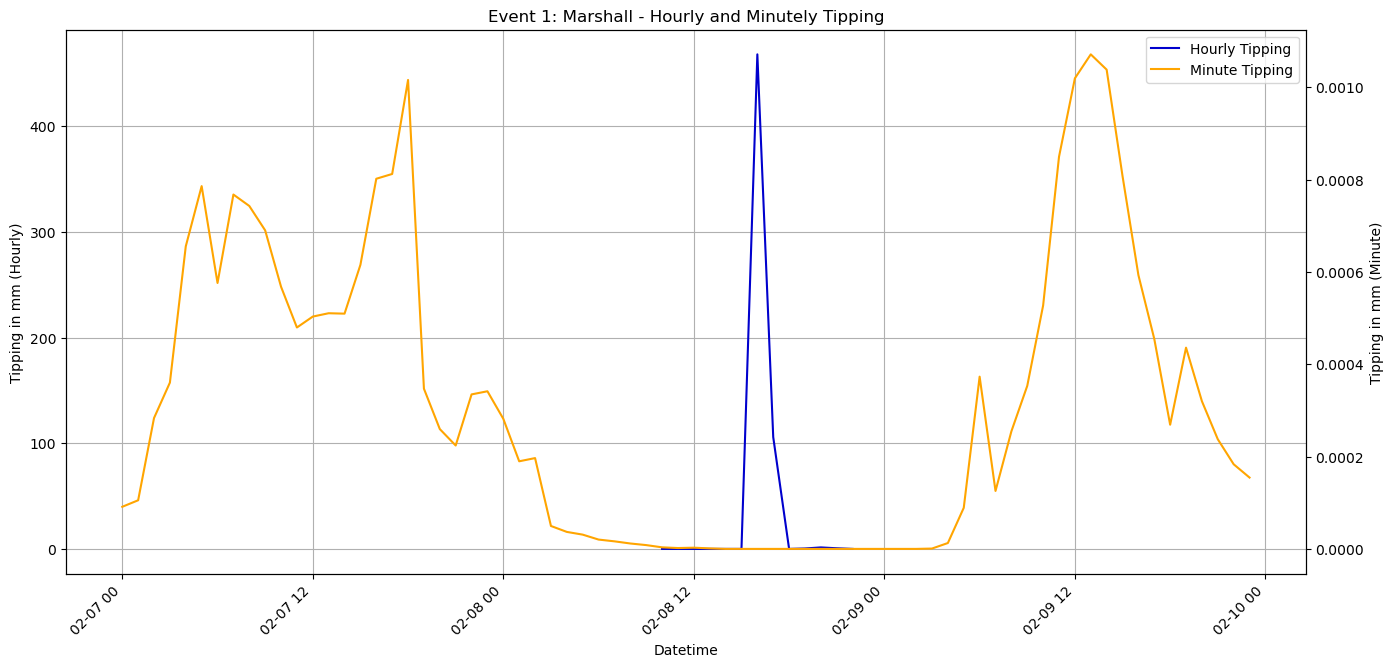

In [76]:
# Convert location_tp to Pandas Series
location_tp_pd = location_tp.to_pandas()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df.index, filtered_df["tipping"], color='mediumblue', label="Hourly Tipping")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(location_tp_pd.index, location_tp_pd.values, color='orange', label="Minute Tipping")
ax2.set_ylabel("Tipping in mm (Minute)")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Marshall - Hourly and Minutely Tipping")

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()




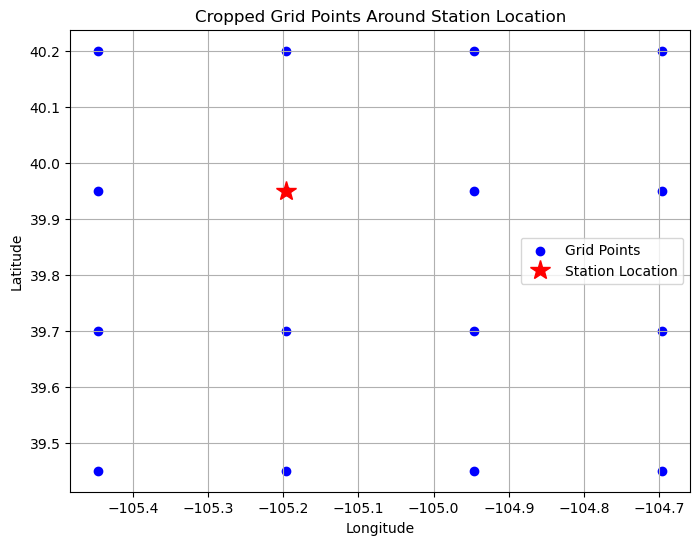

In [75]:
import matplotlib.pyplot as plt

def plot_cropped_grid(ds_cropped, station_lat, station_lon, lat_name='latitude', lon_name='longitude'):
    lats = ds_cropped[lat_name].values
    lons = ds_cropped[lon_name].values

    # Create a meshgrid for plotting
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # Plot the grid points
    plt.figure(figsize=(8, 6))
    plt.scatter(lon_grid, lat_grid, marker='o', color='blue', label='Grid Points')

    # Plot the station location
    plt.plot(station_lon, station_lat, 'r*', markersize=15, label='Station Location')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Cropped Grid Points Around Station Location')
    plt.legend()
    plt.grid(True)
    plt.show()

# After cropping, call the plotting function
ds_cropped = xr.open_dataset(output_path)
plot_cropped_grid(ds_cropped, station_lat, station_lon)


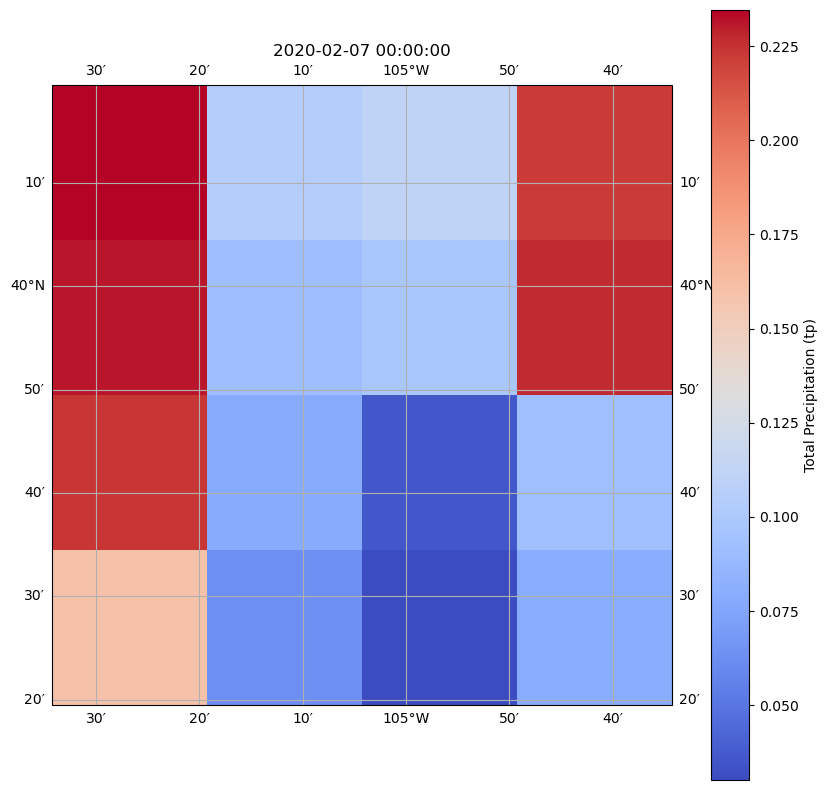

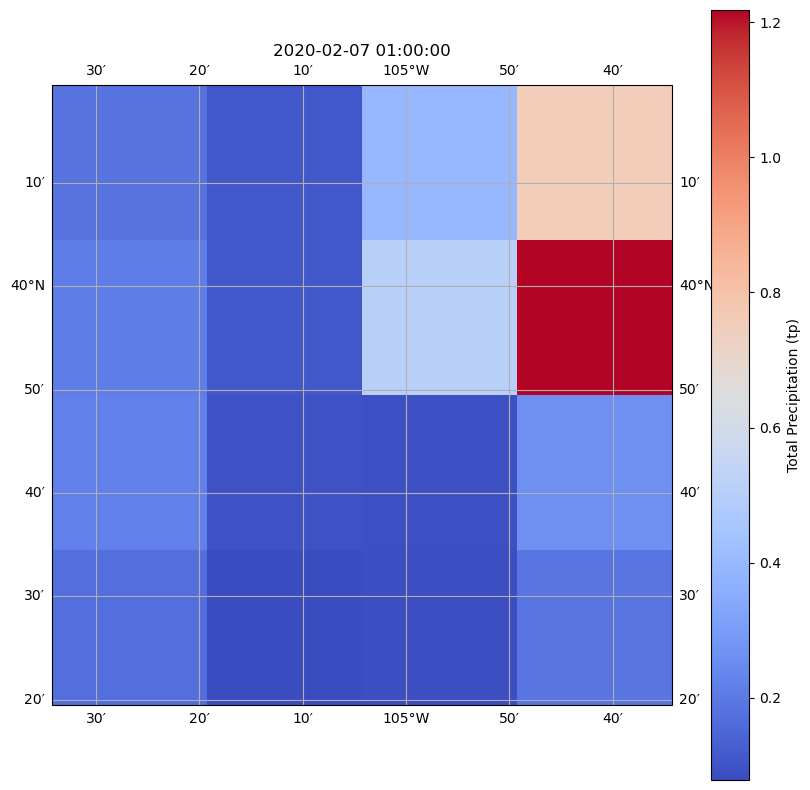

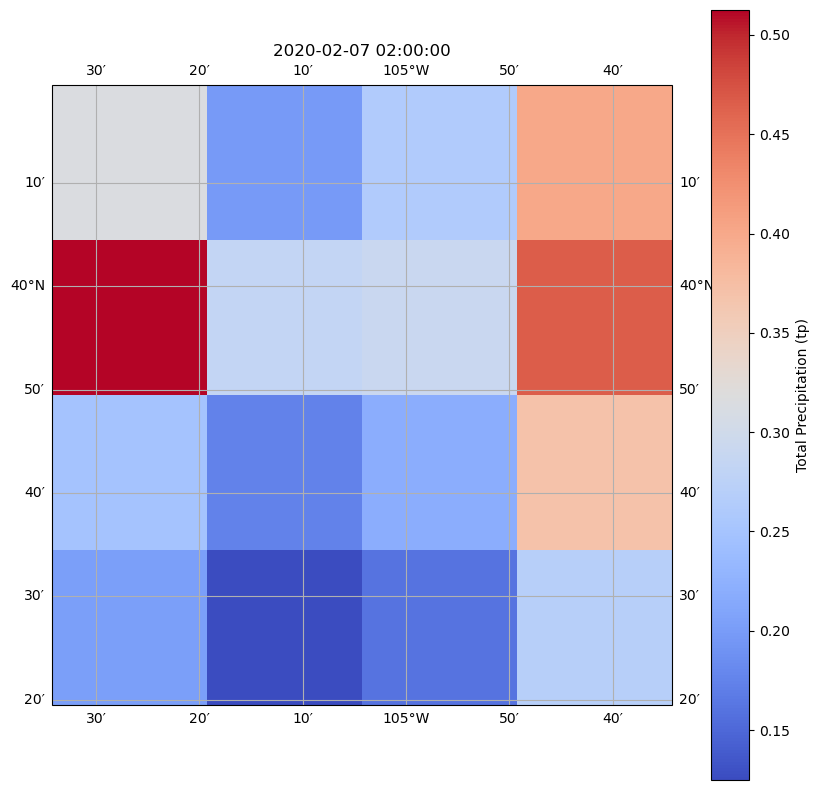

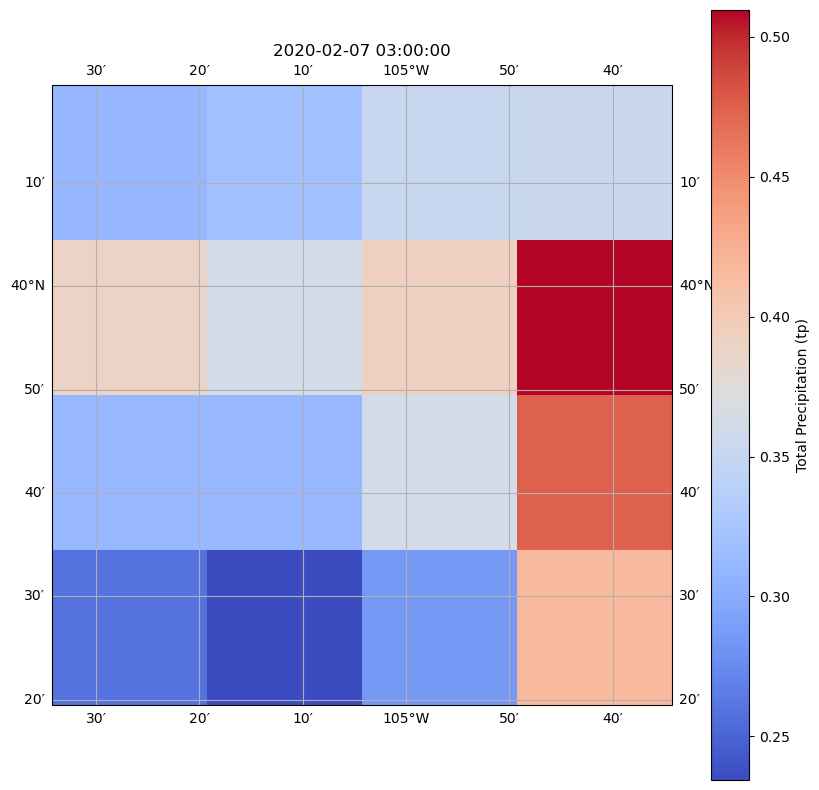

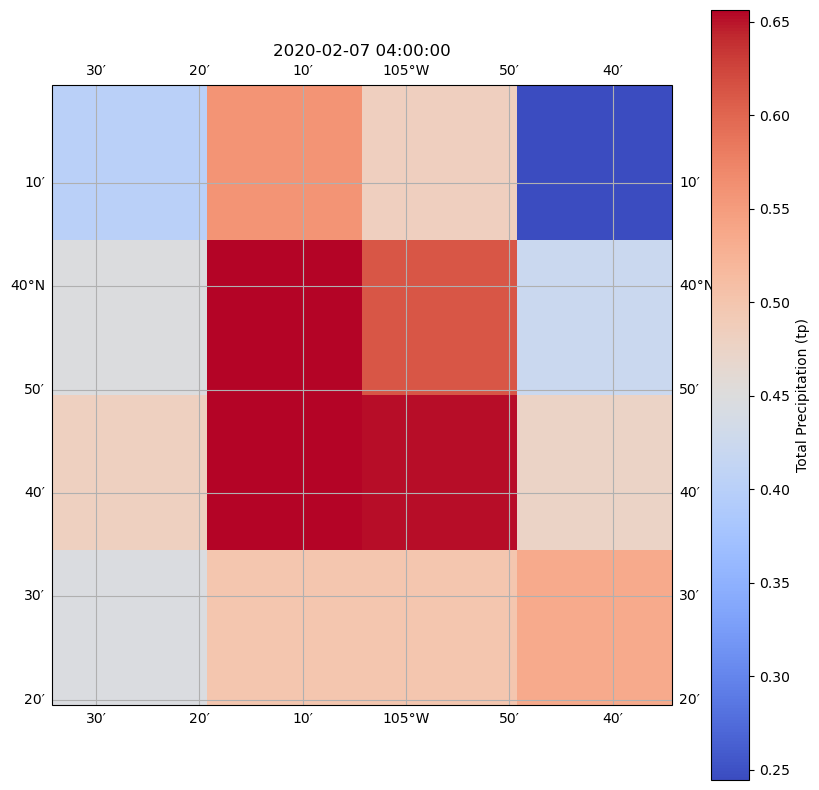

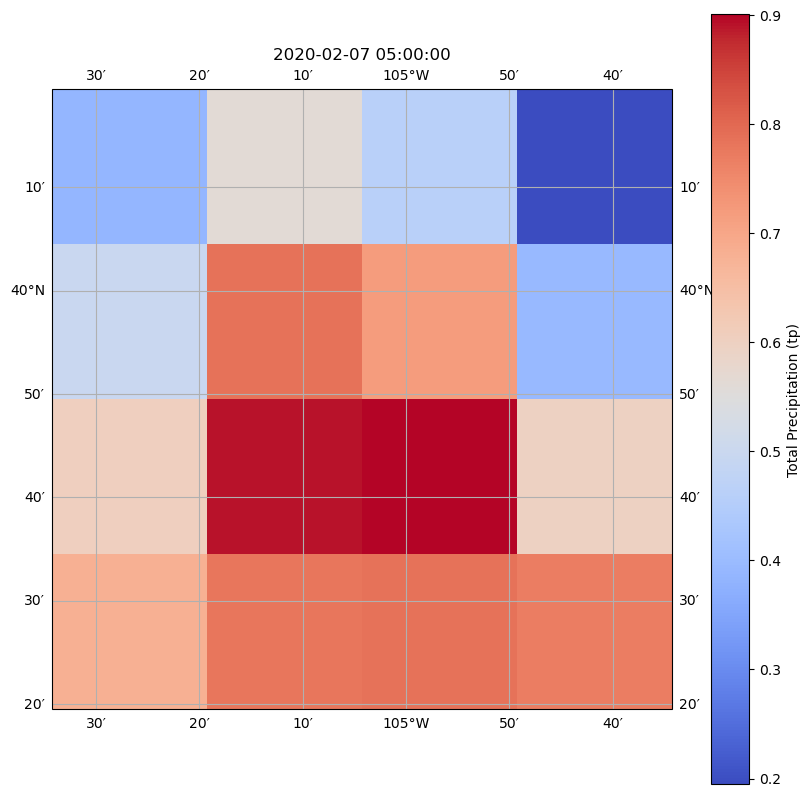

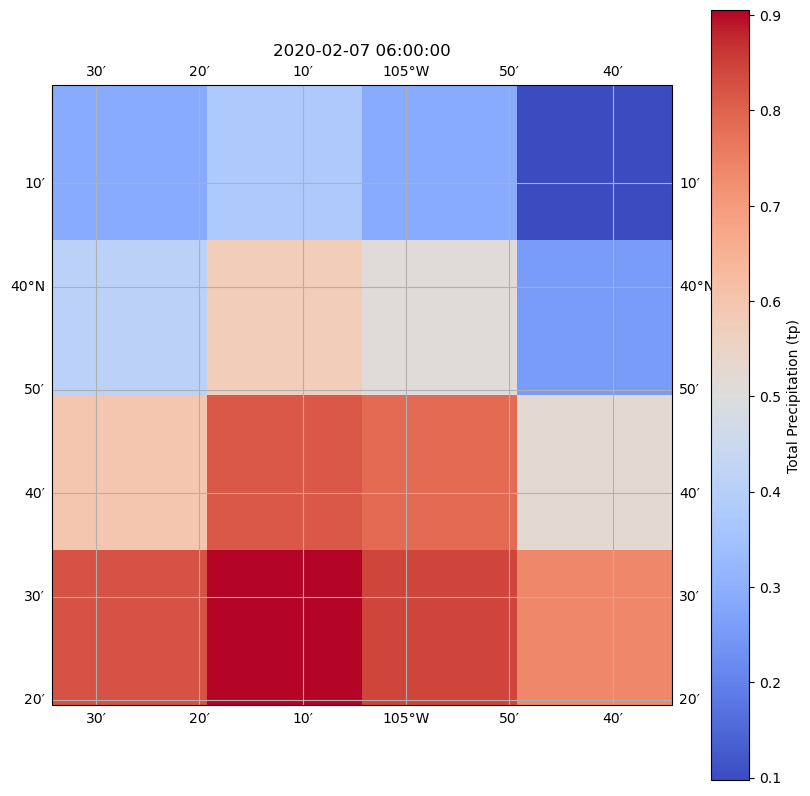

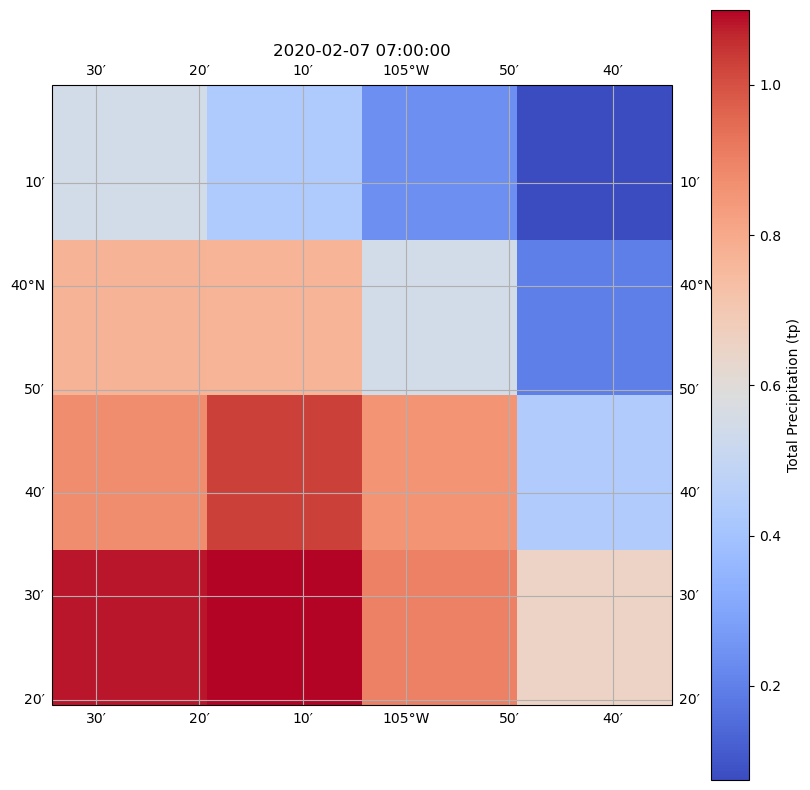

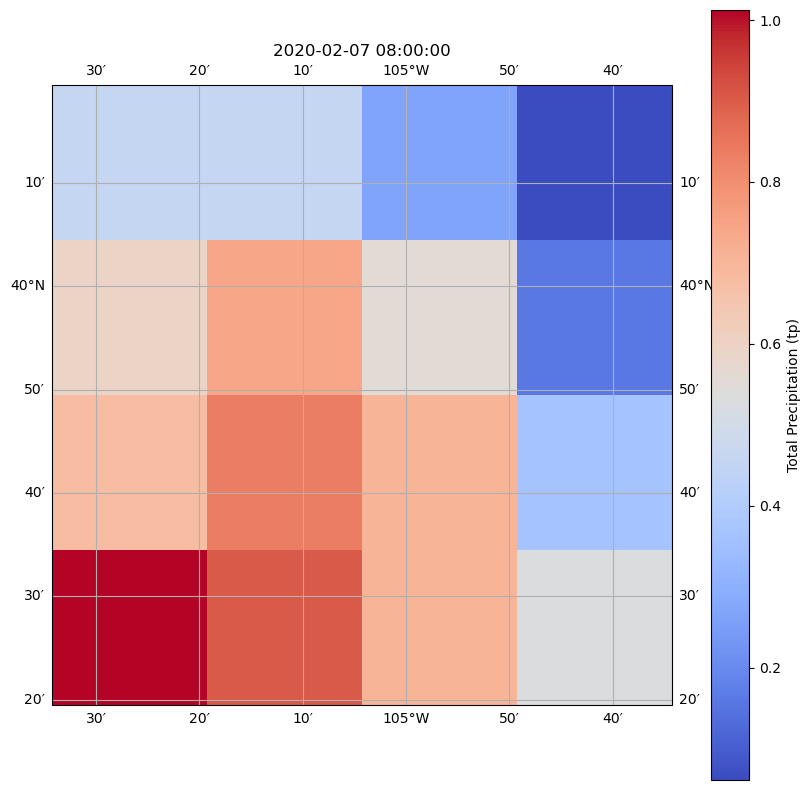

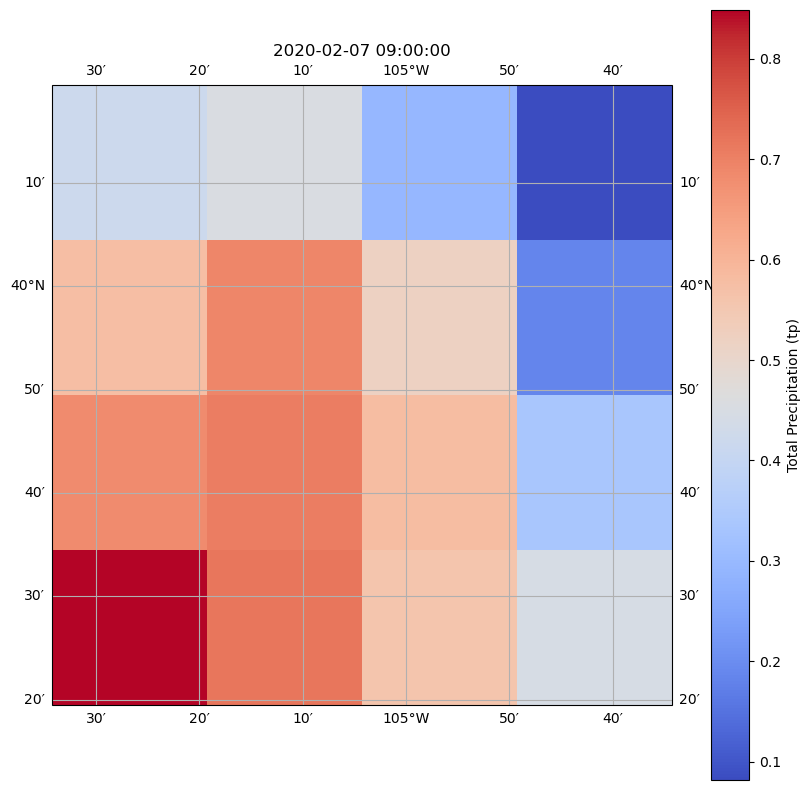

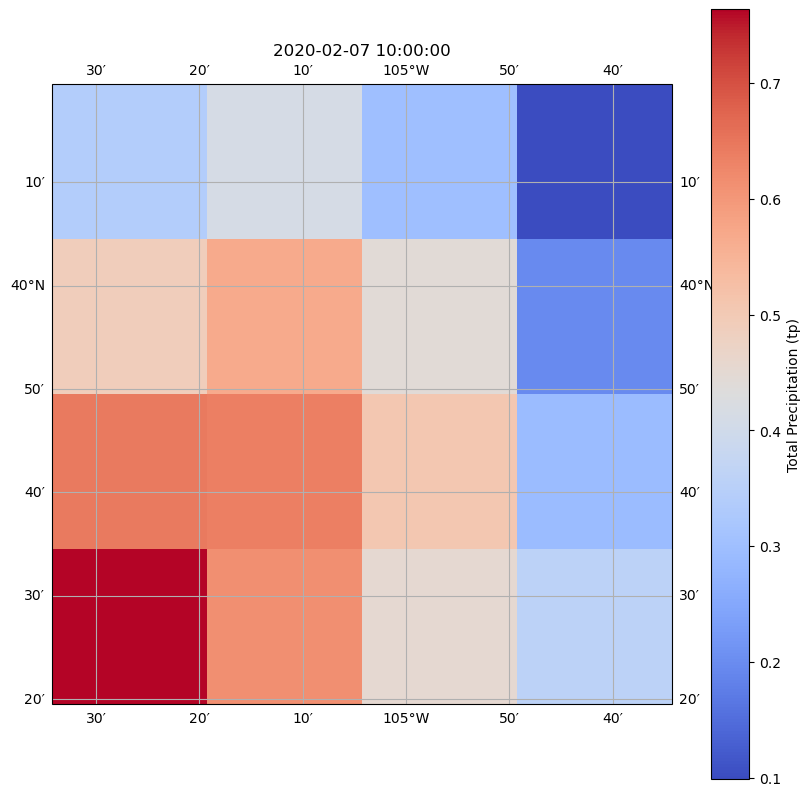

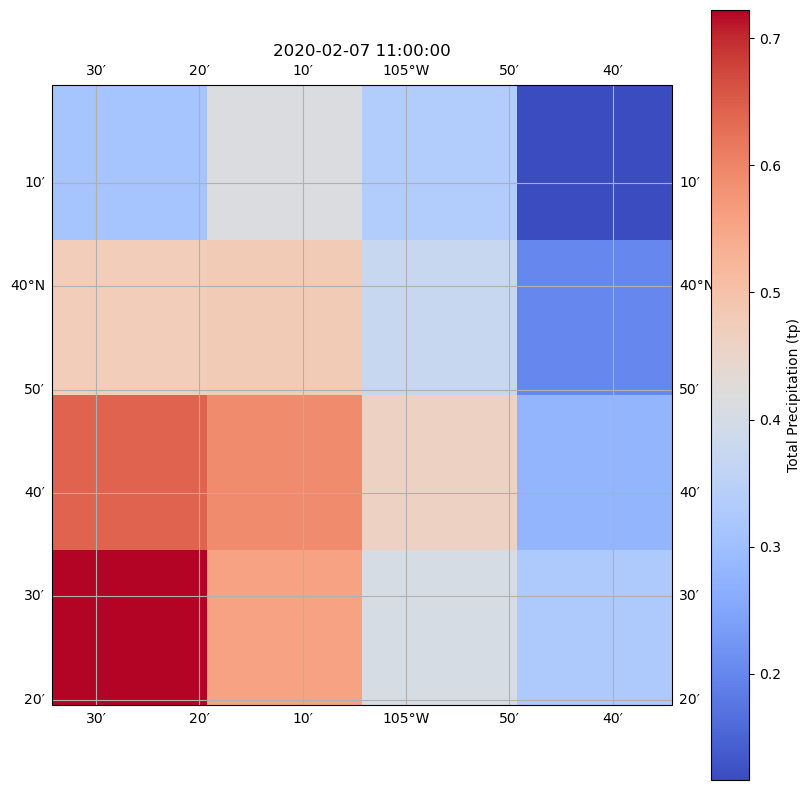

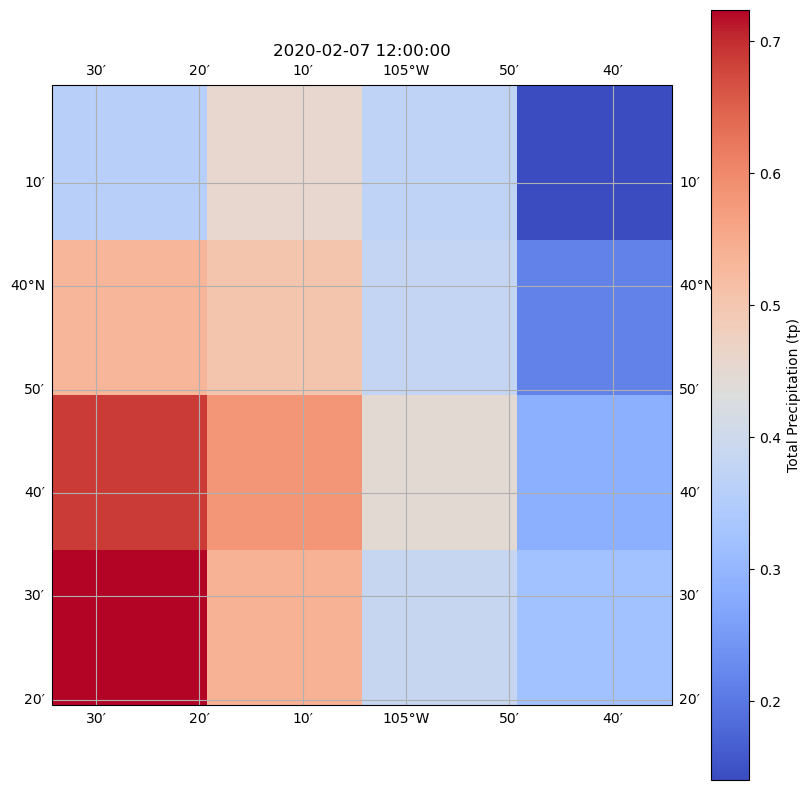

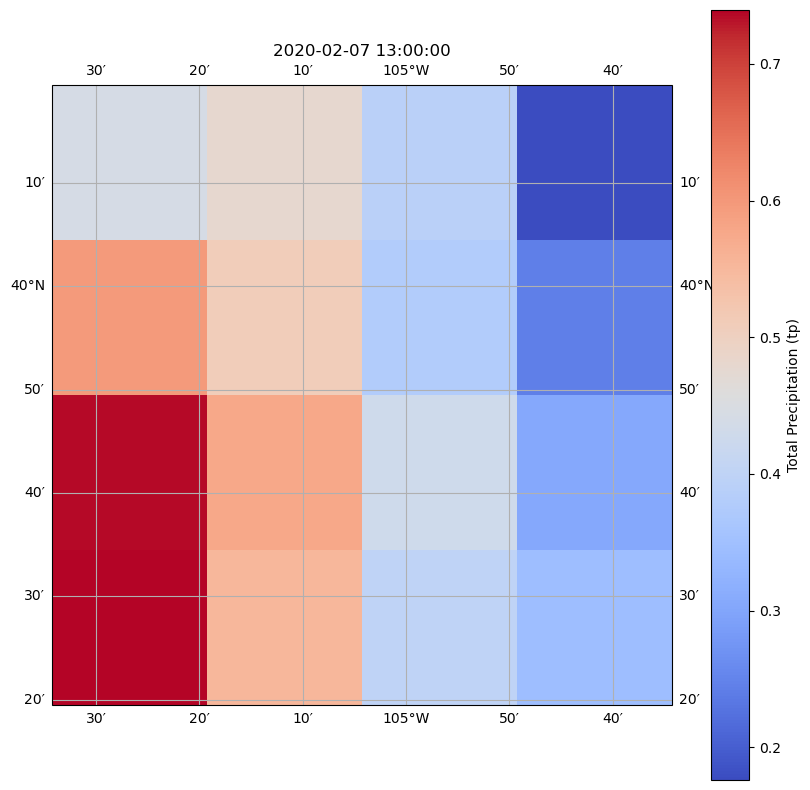

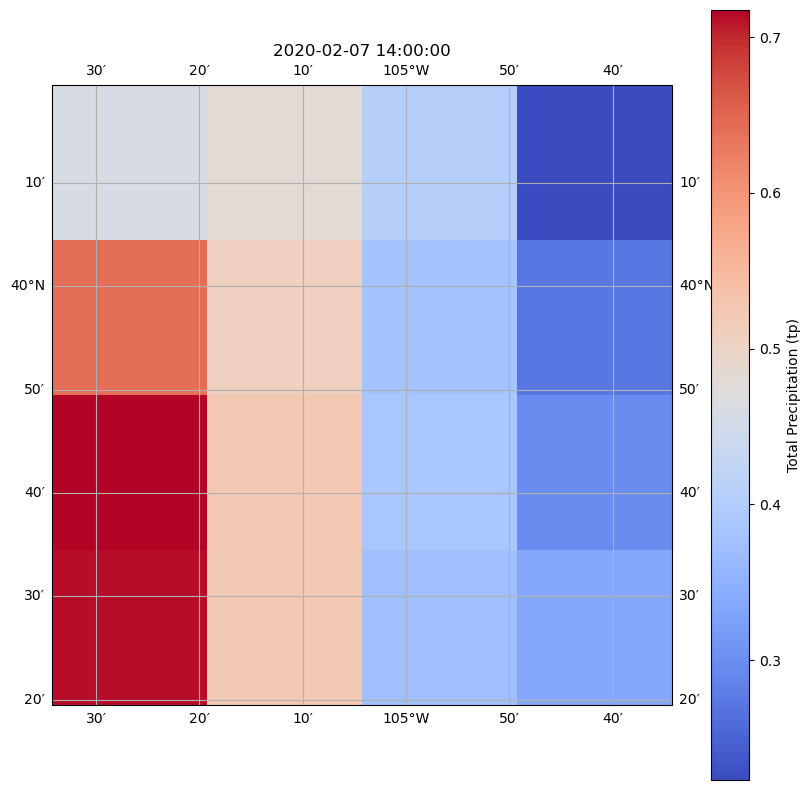

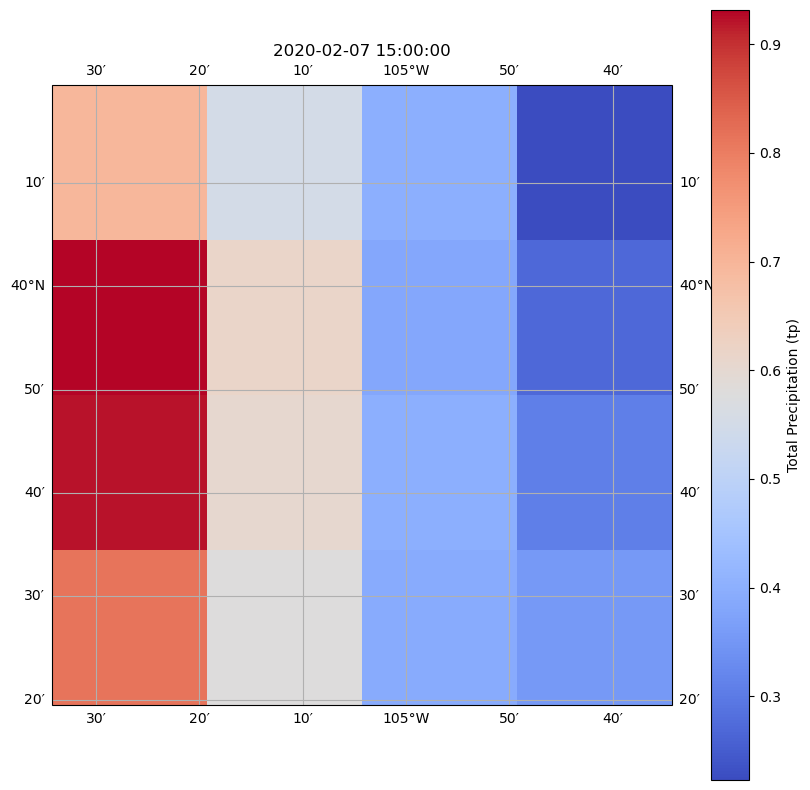

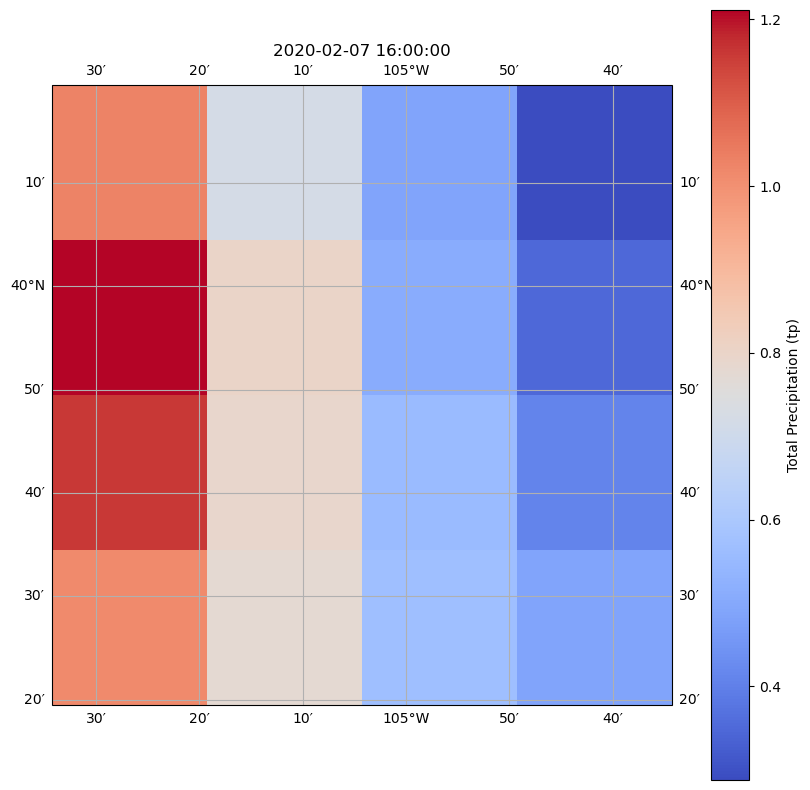

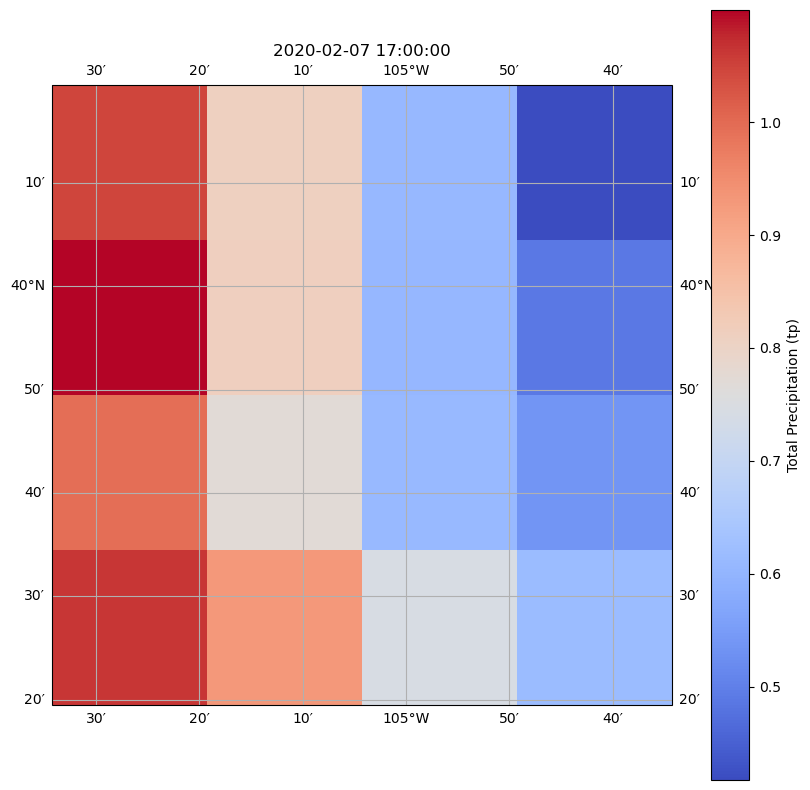

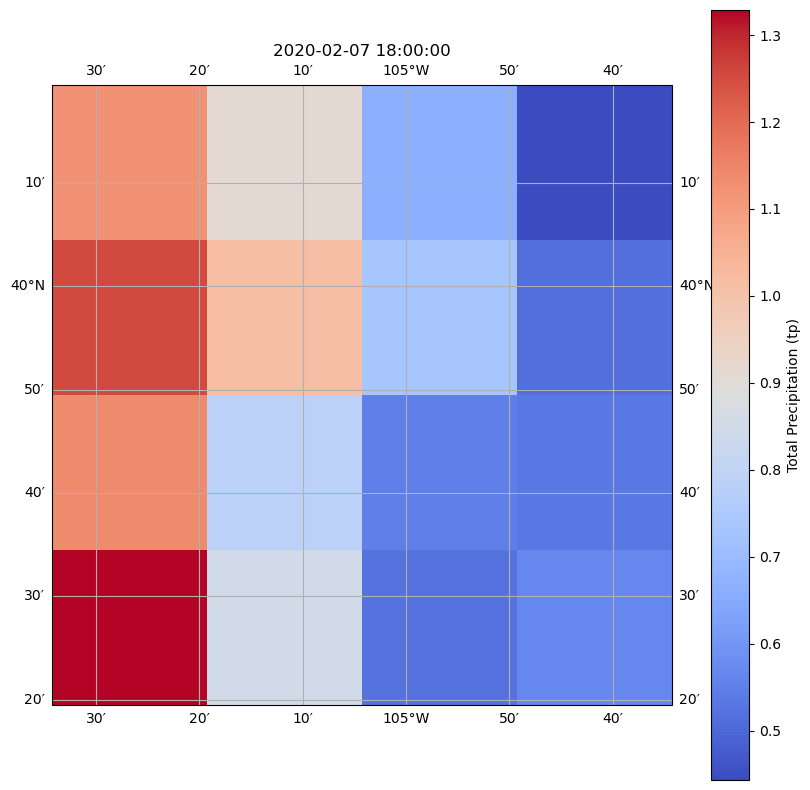

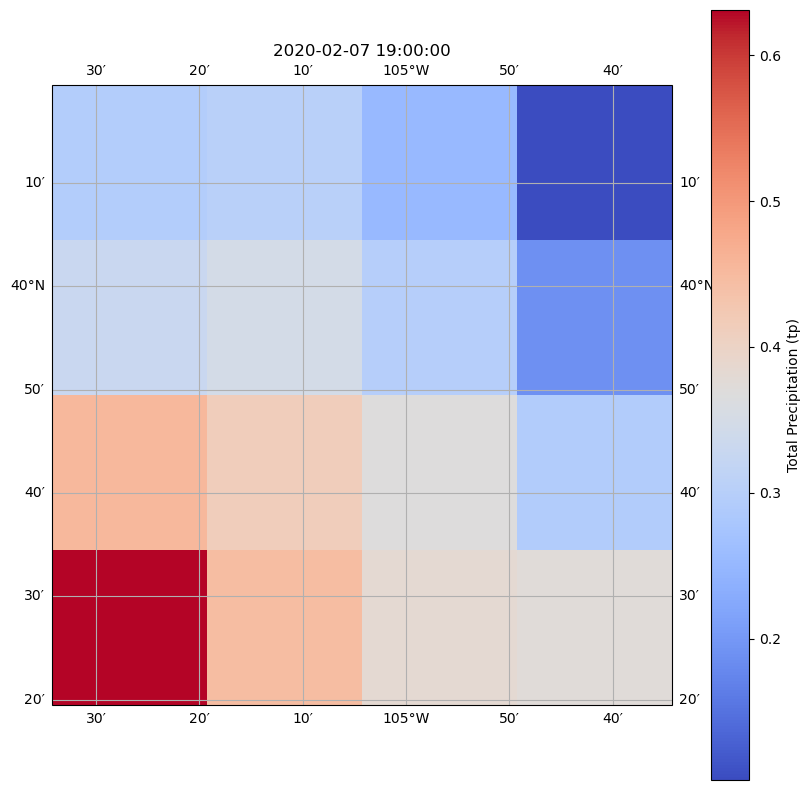

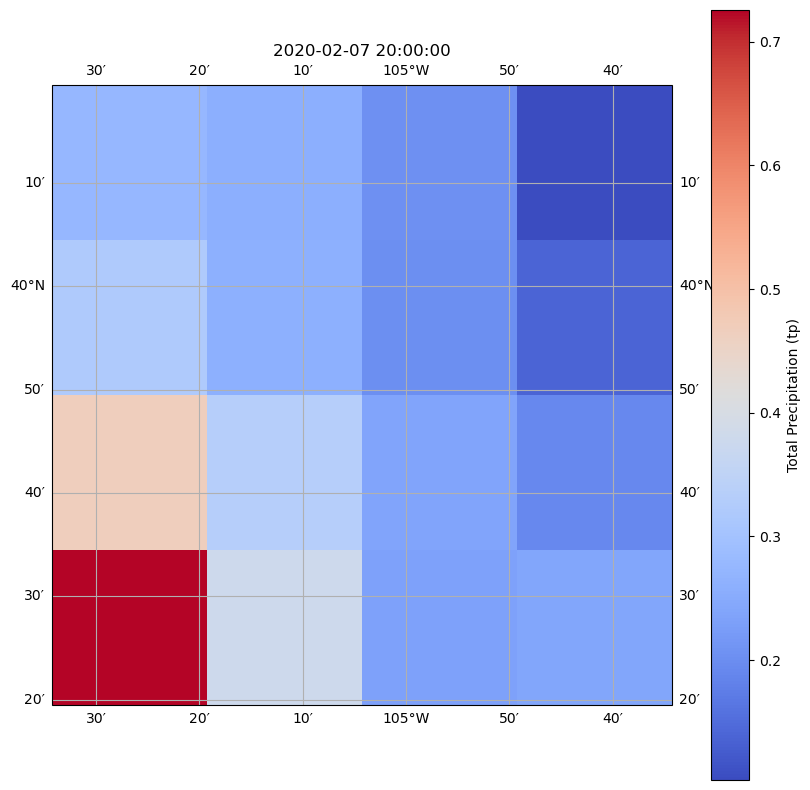

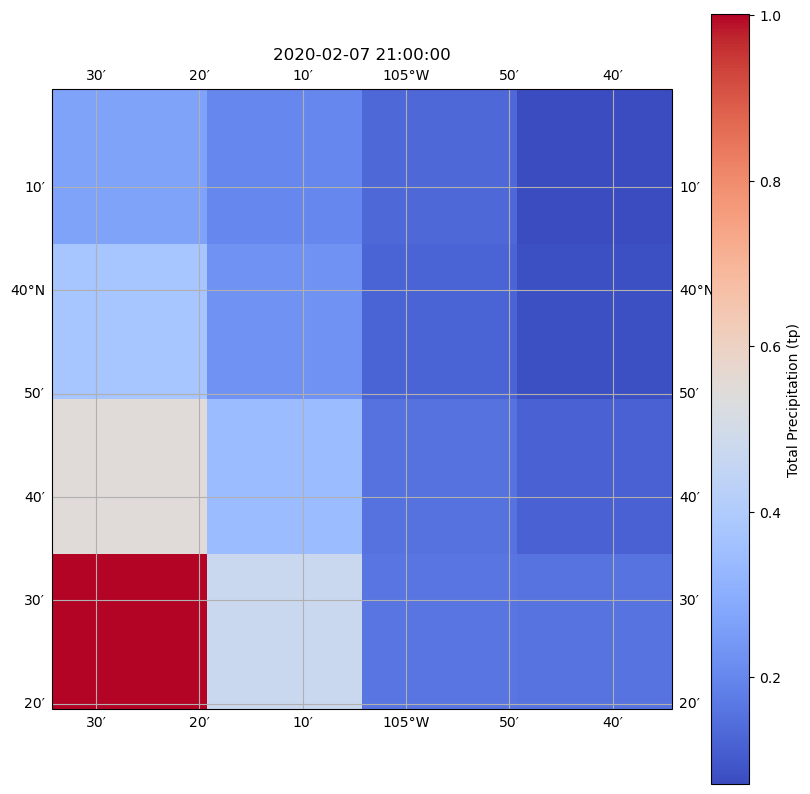

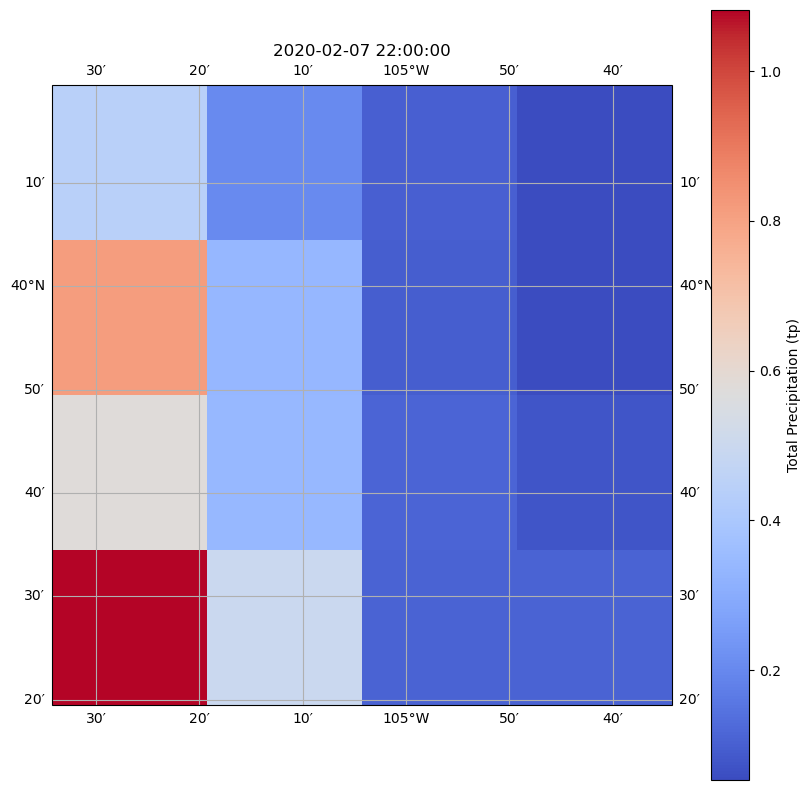

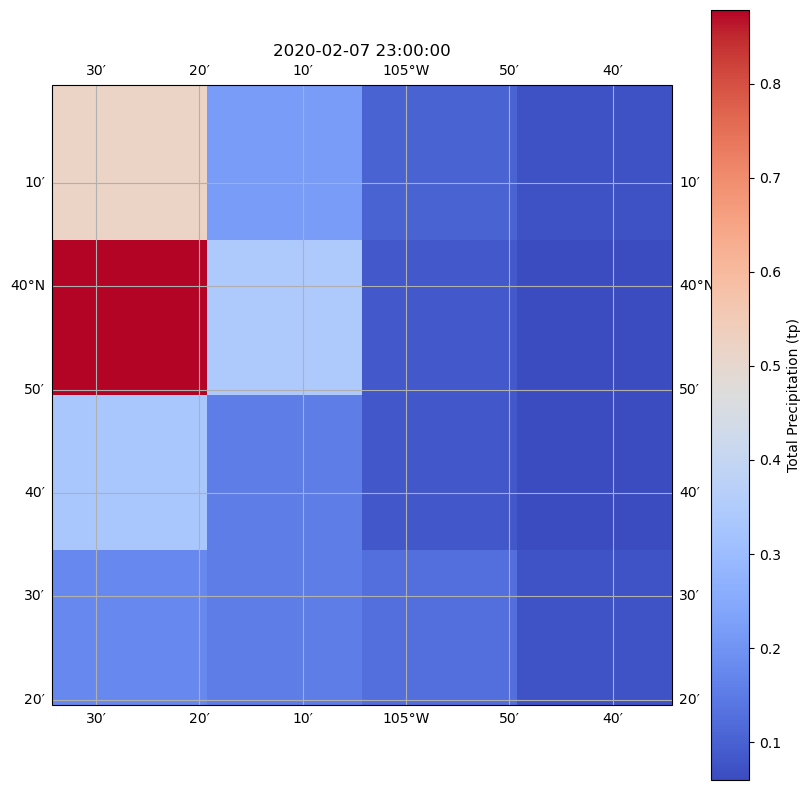

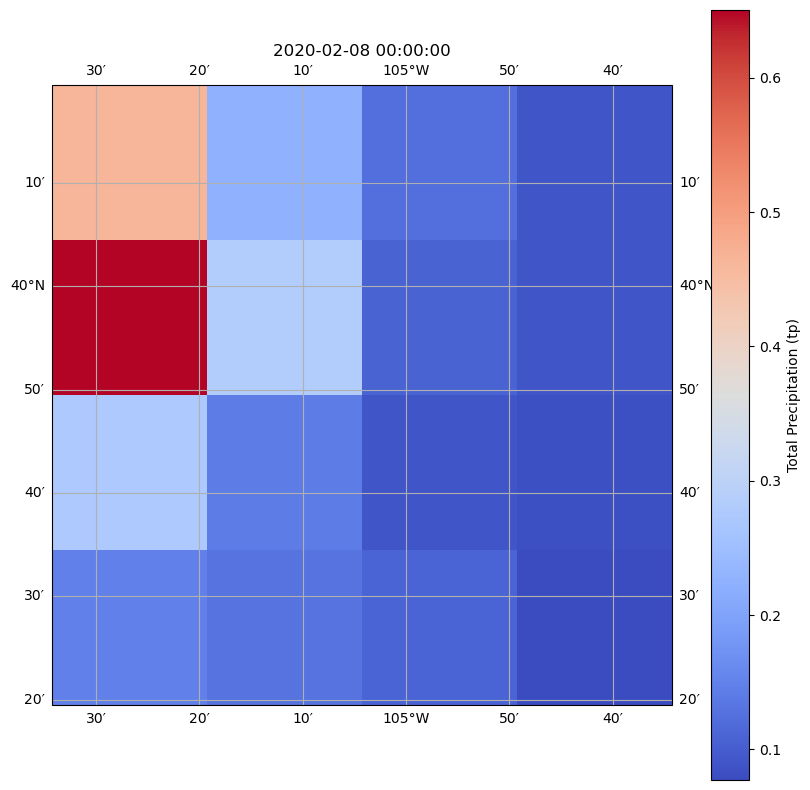

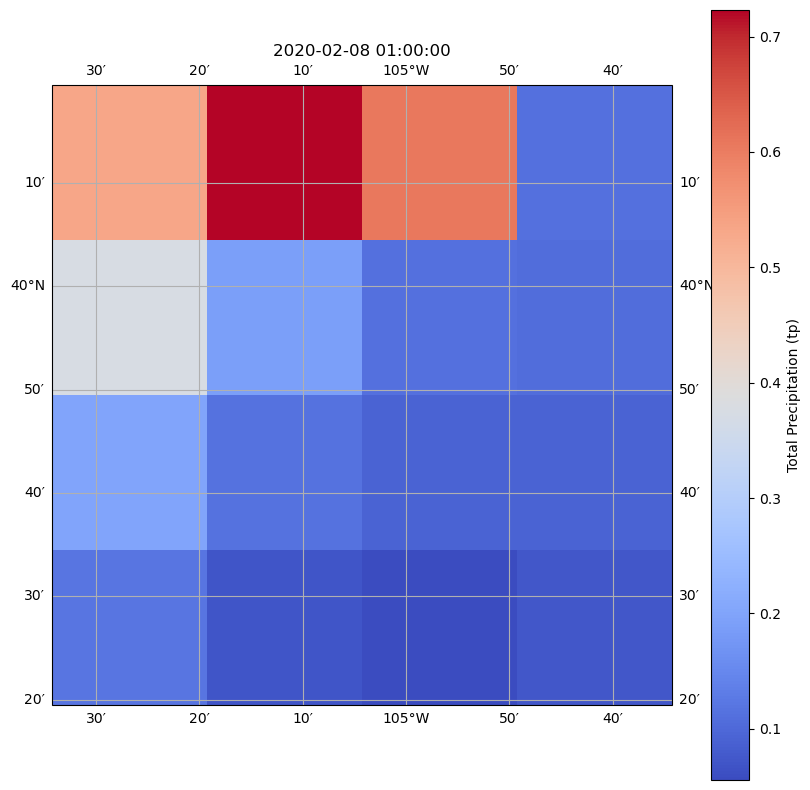

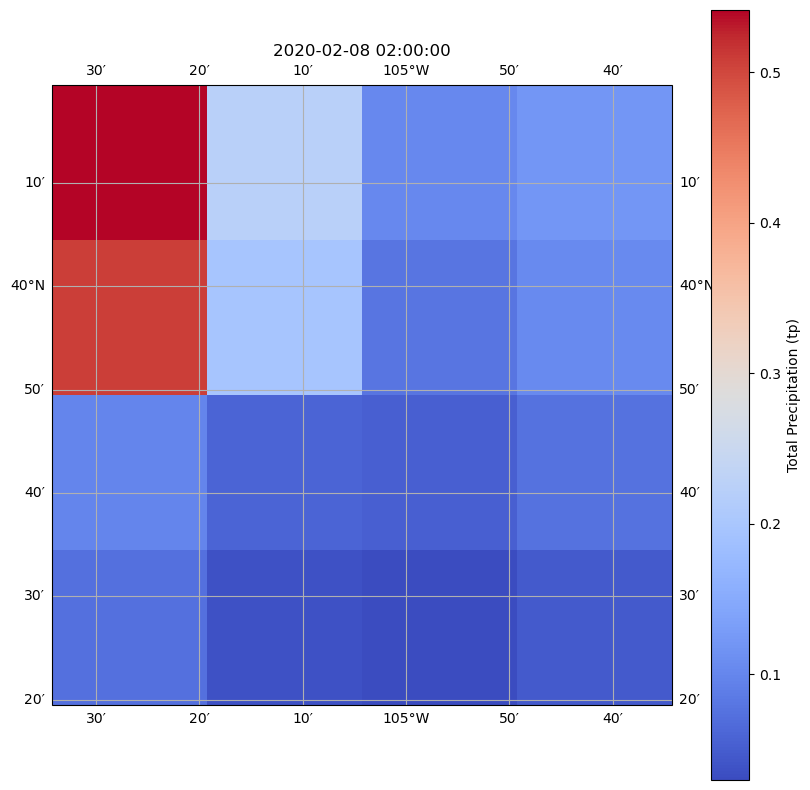

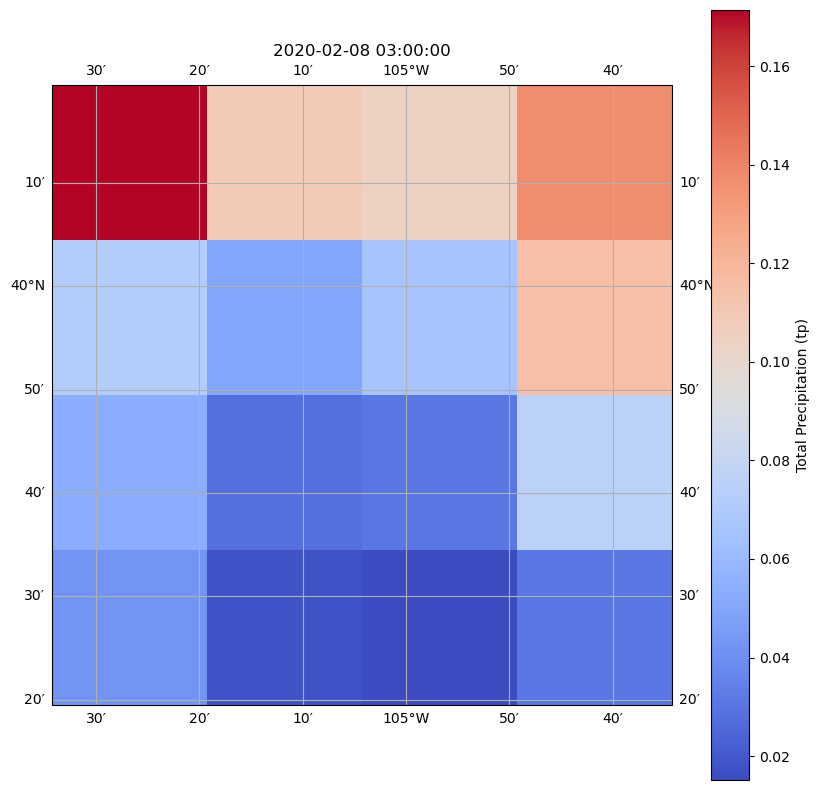

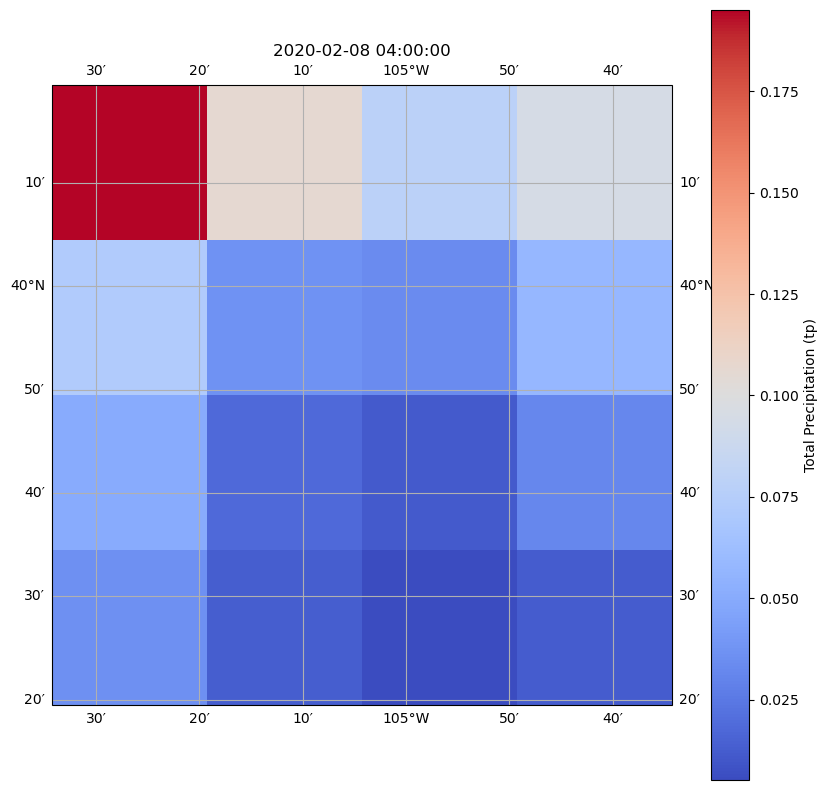

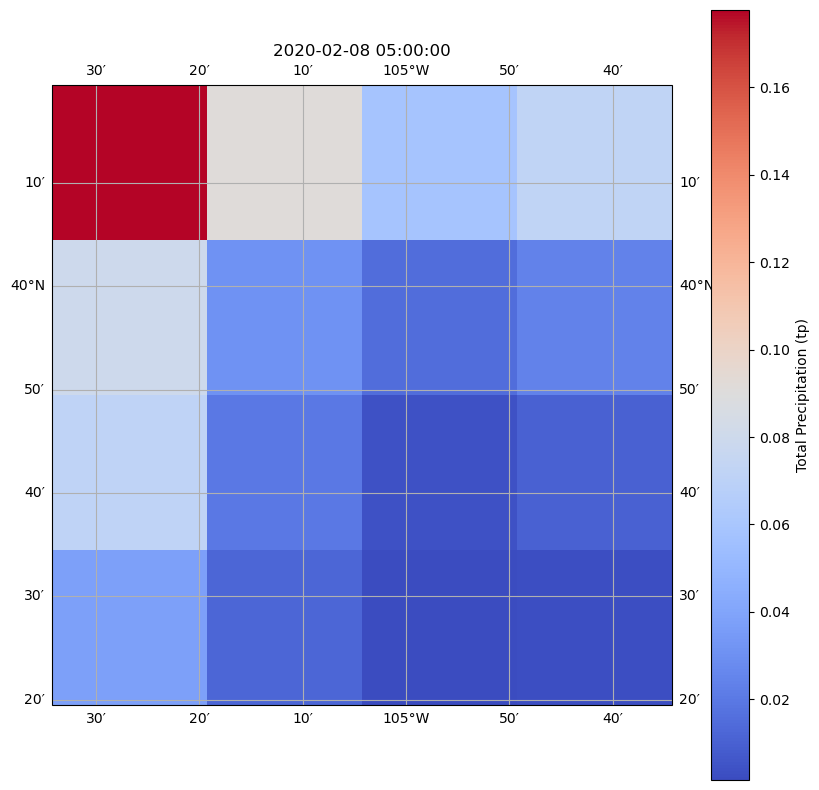

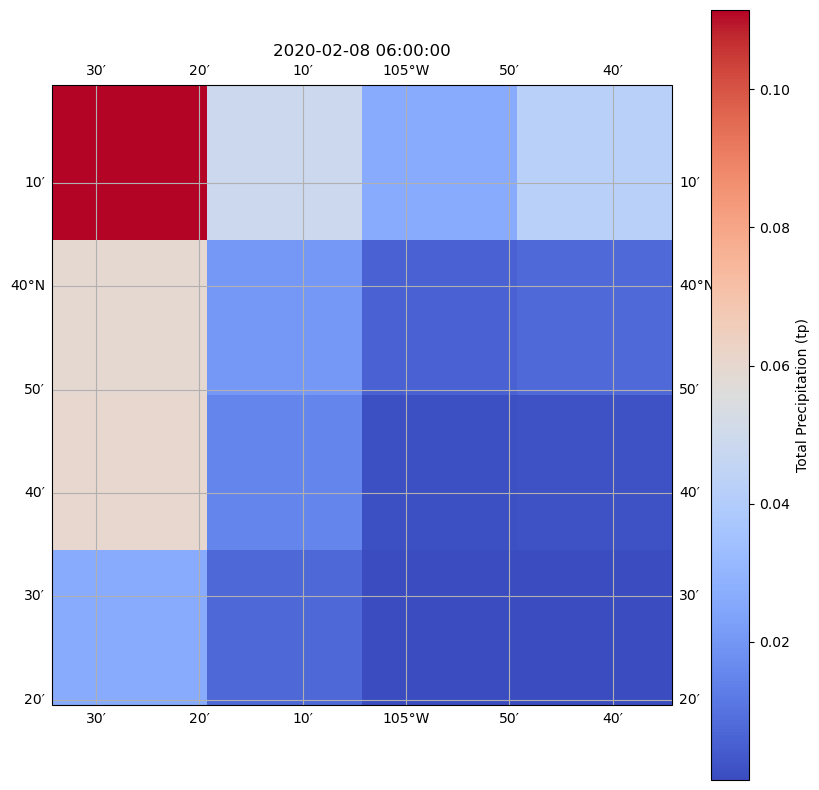

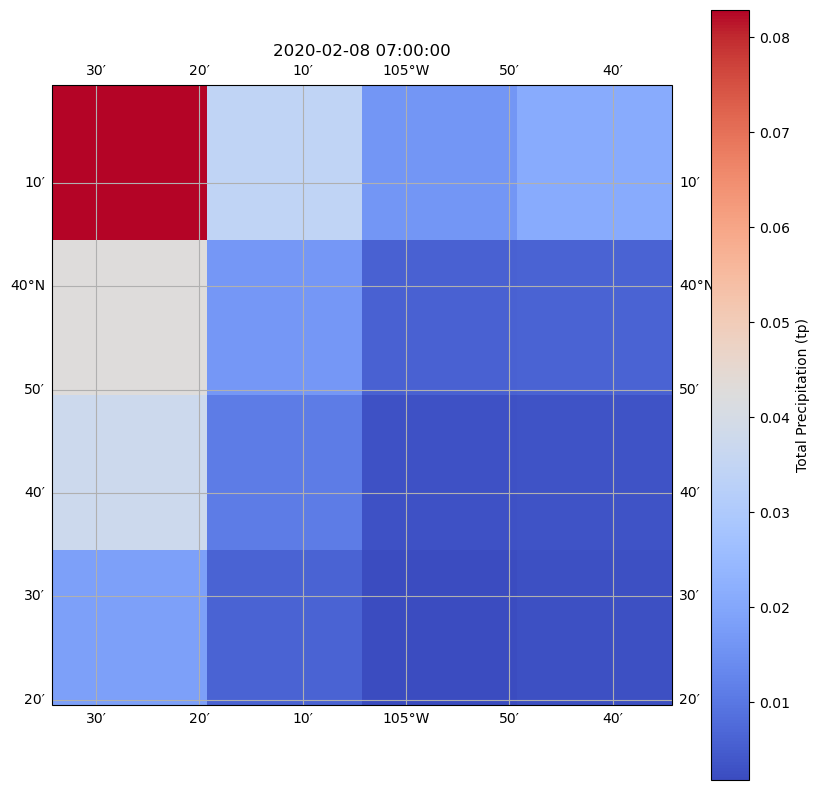

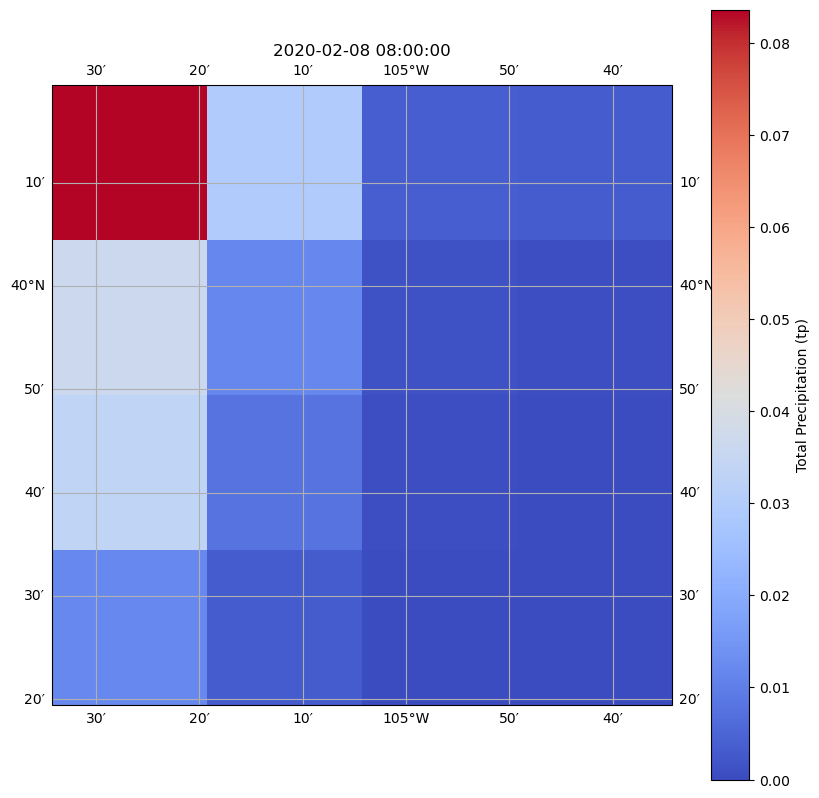

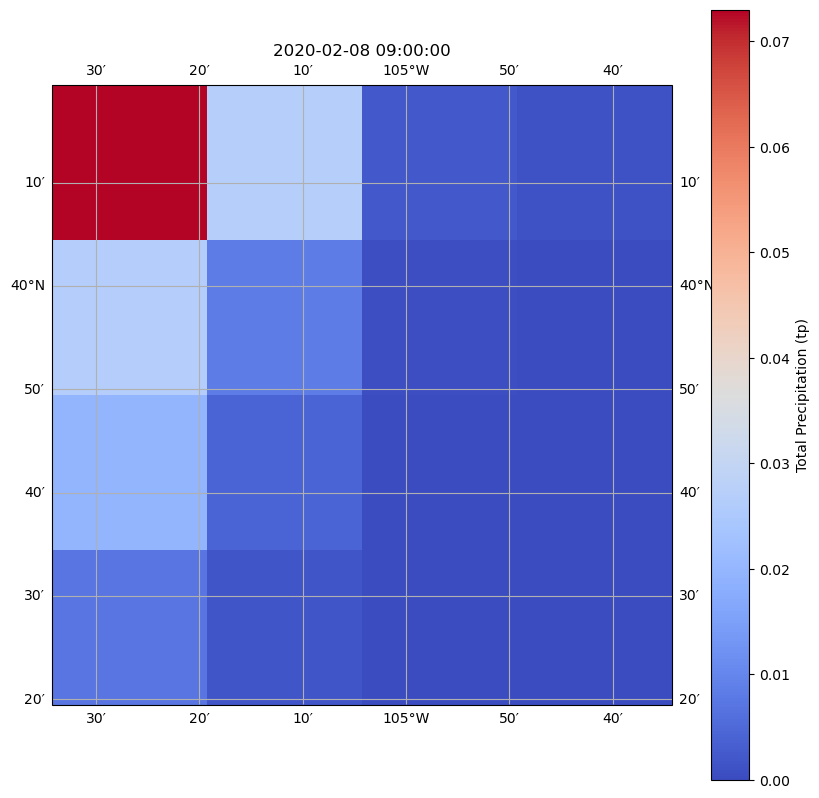

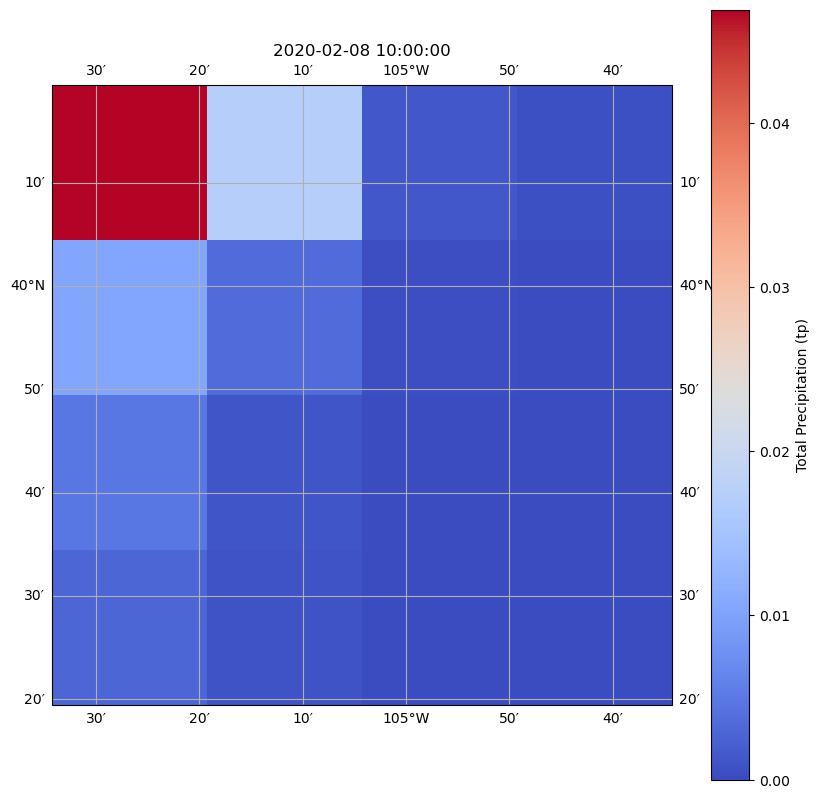

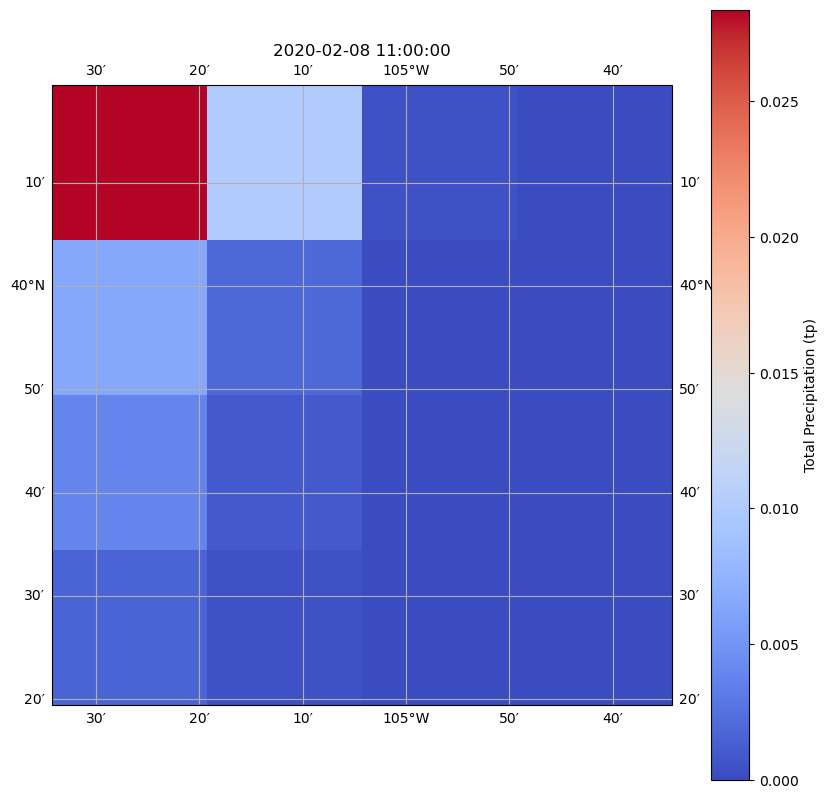

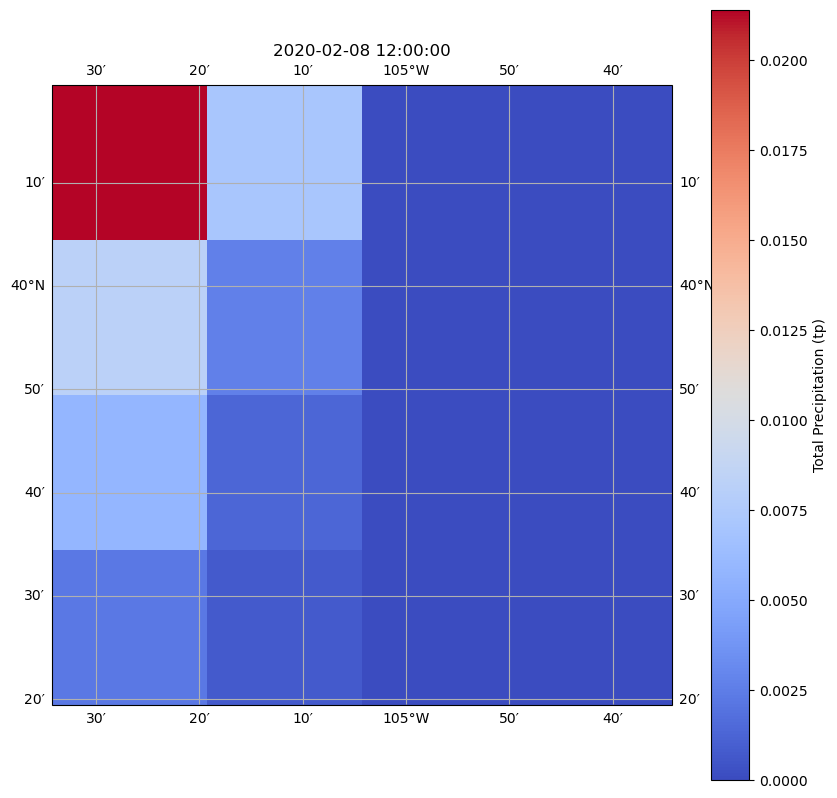

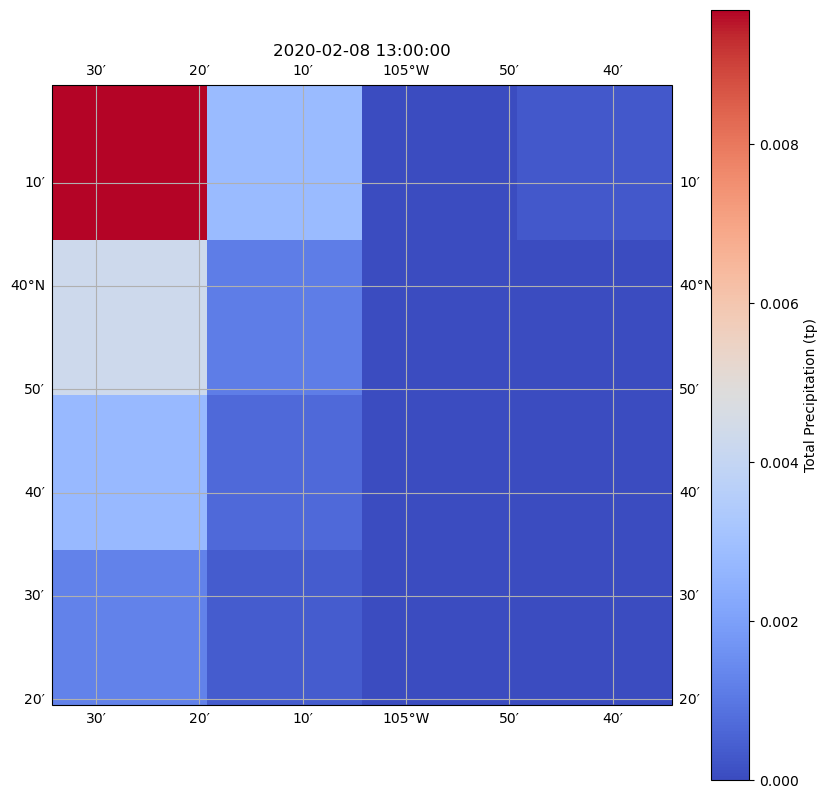

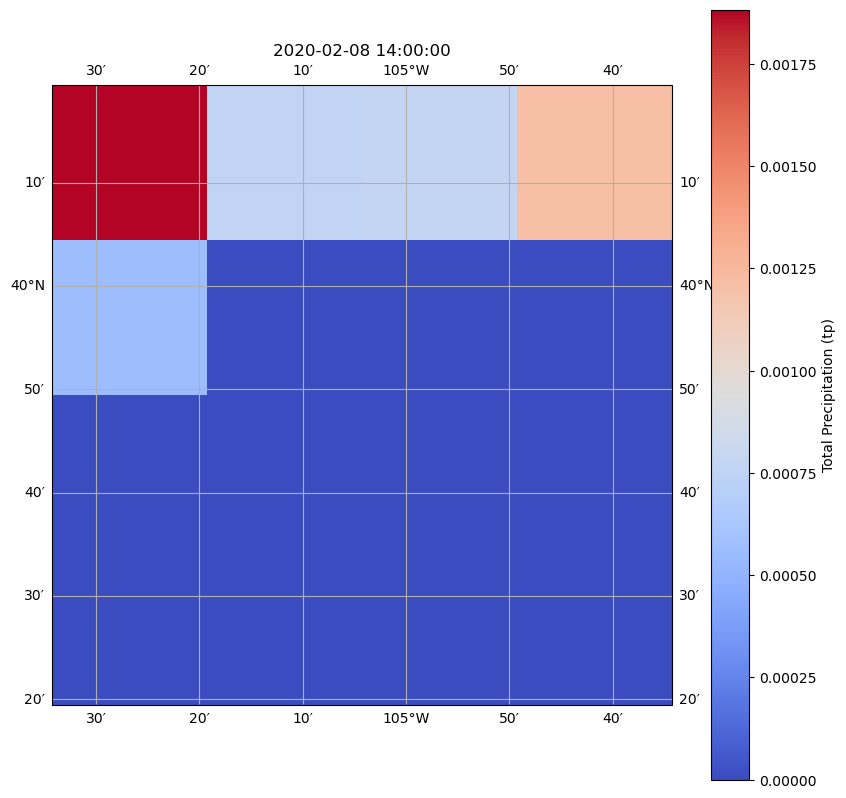

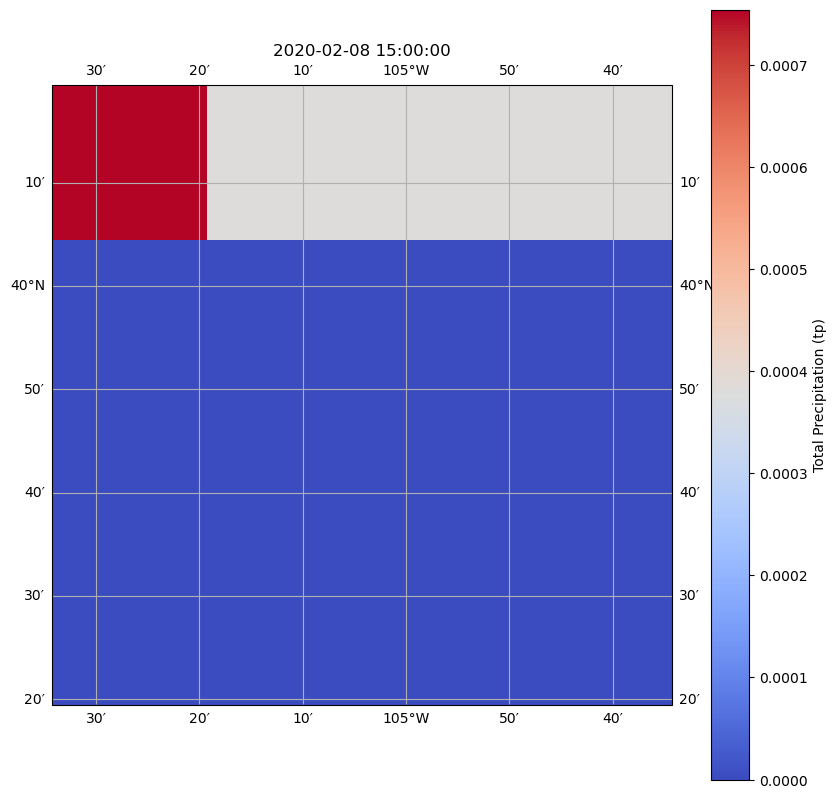

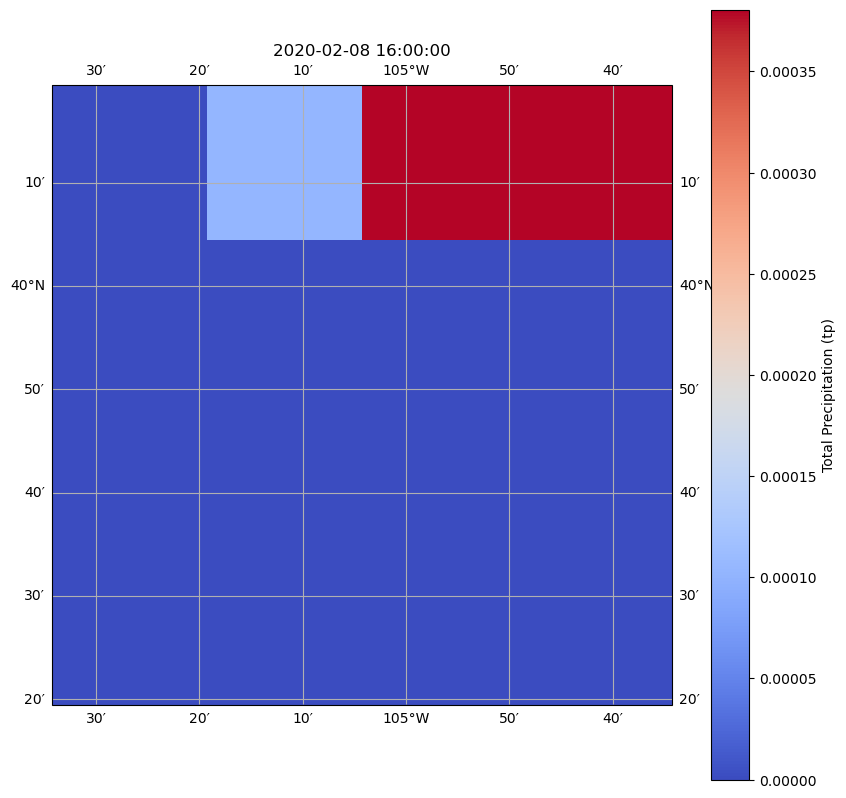

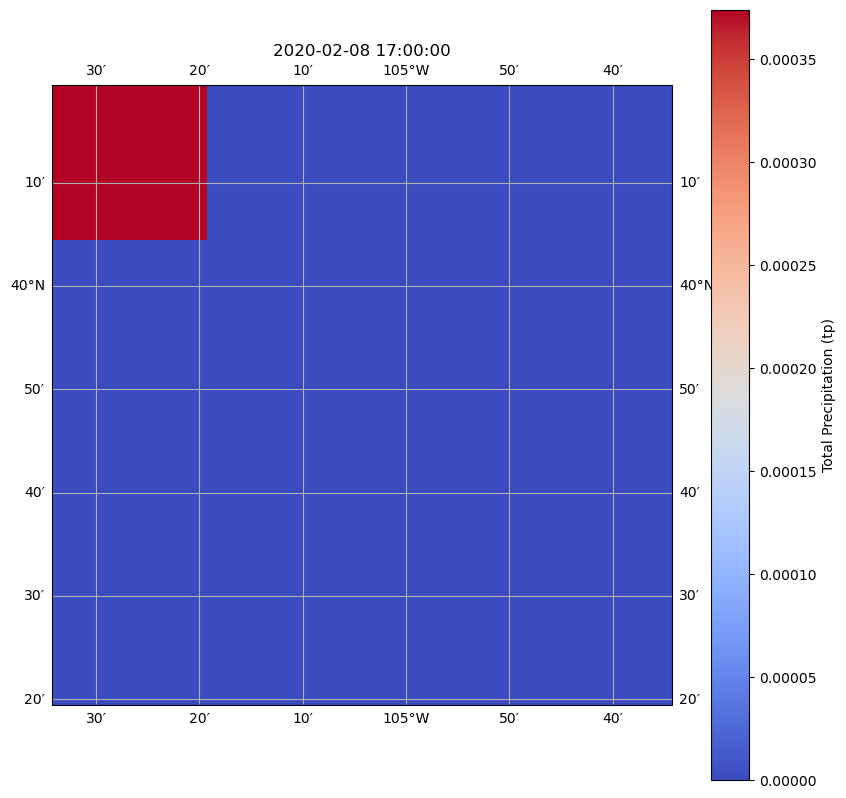

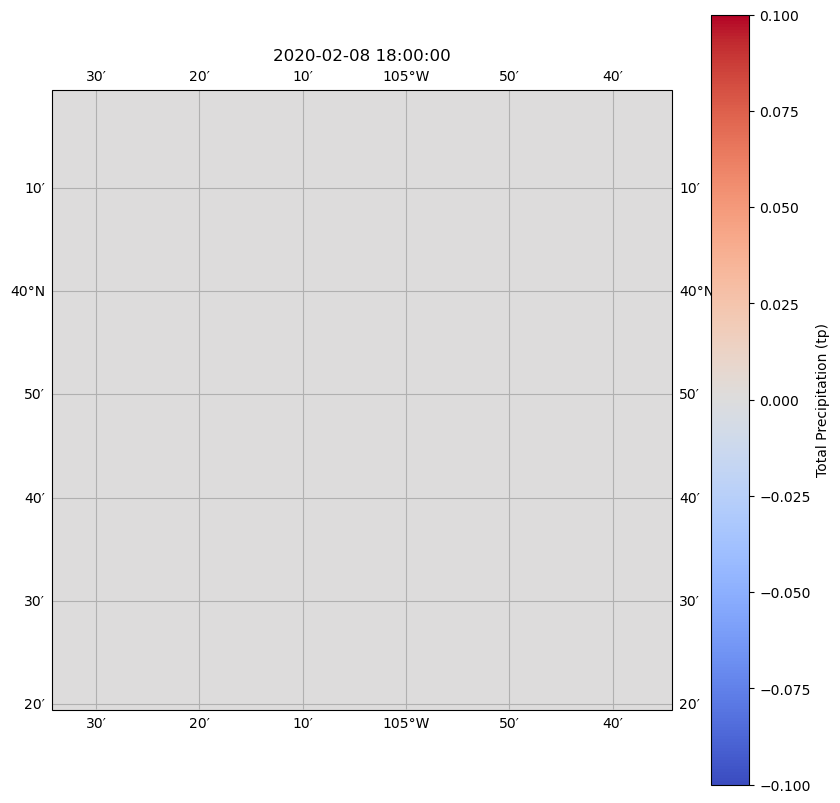

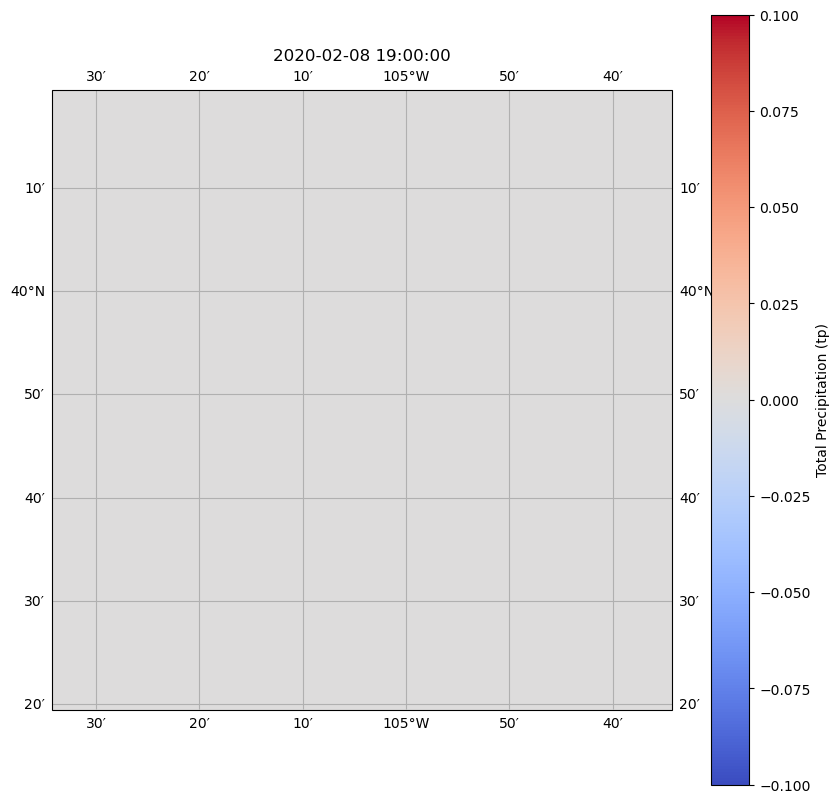

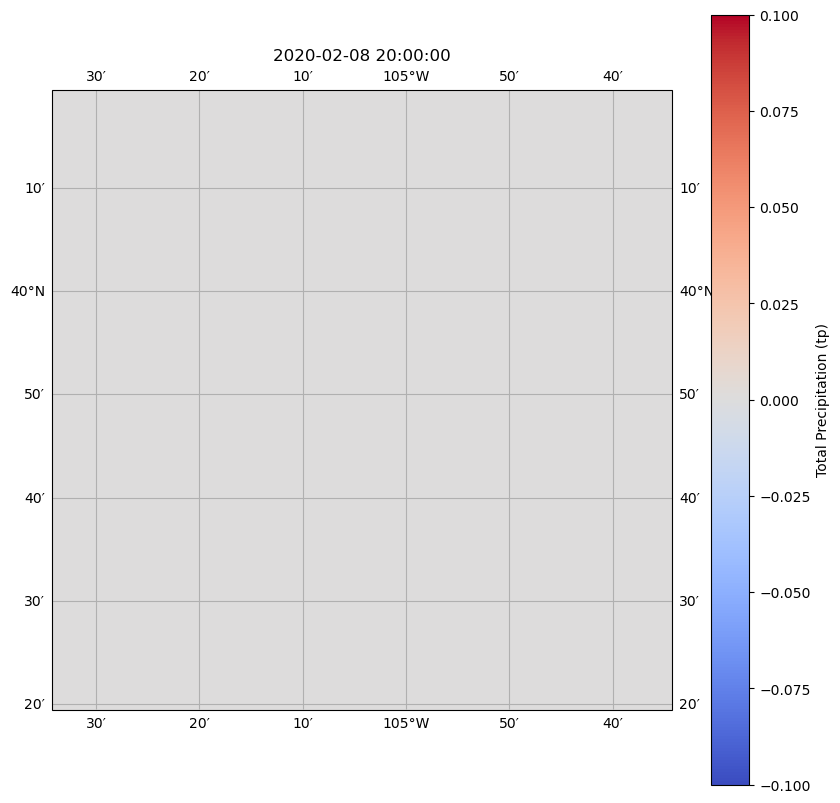

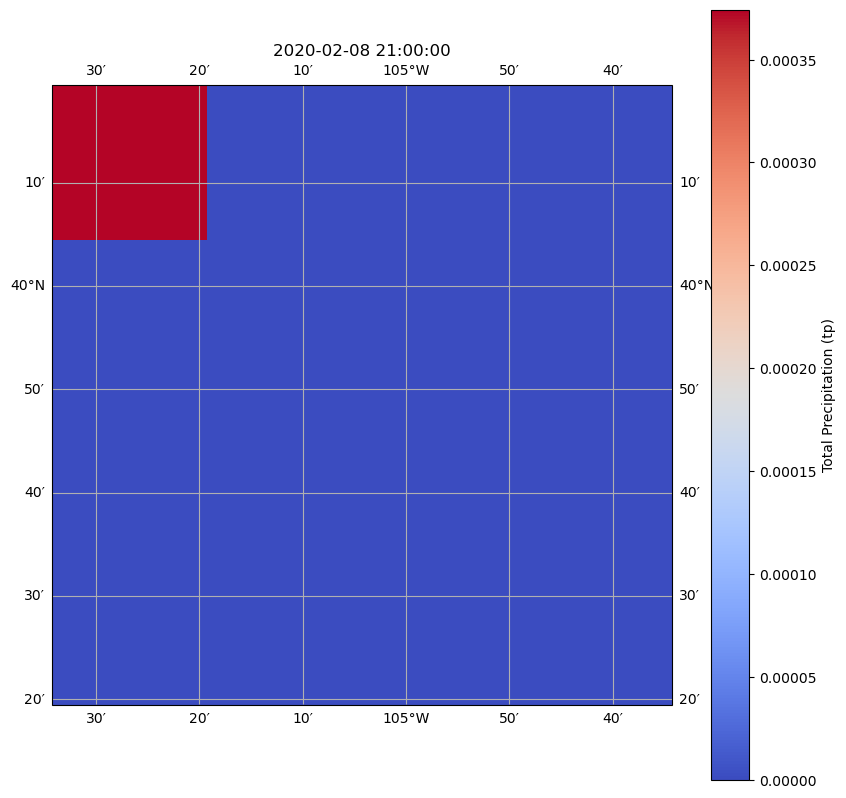

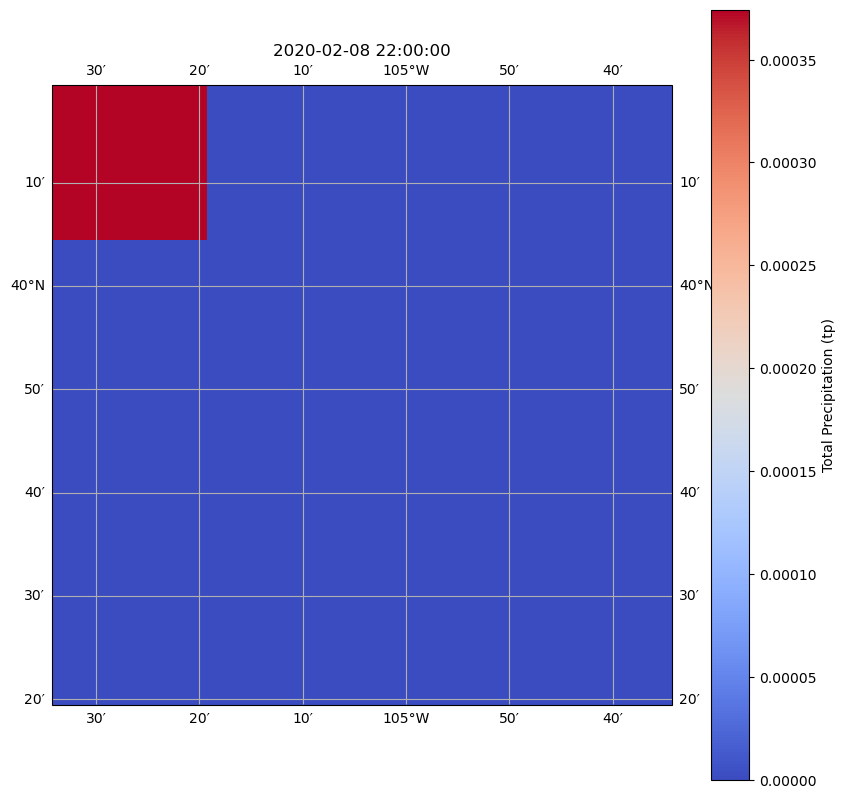

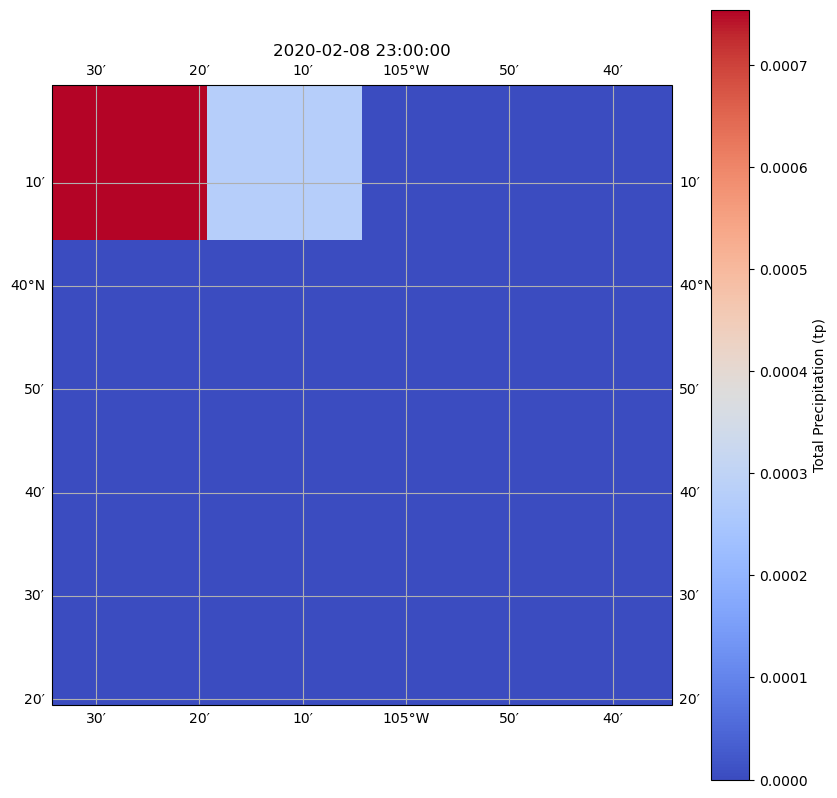

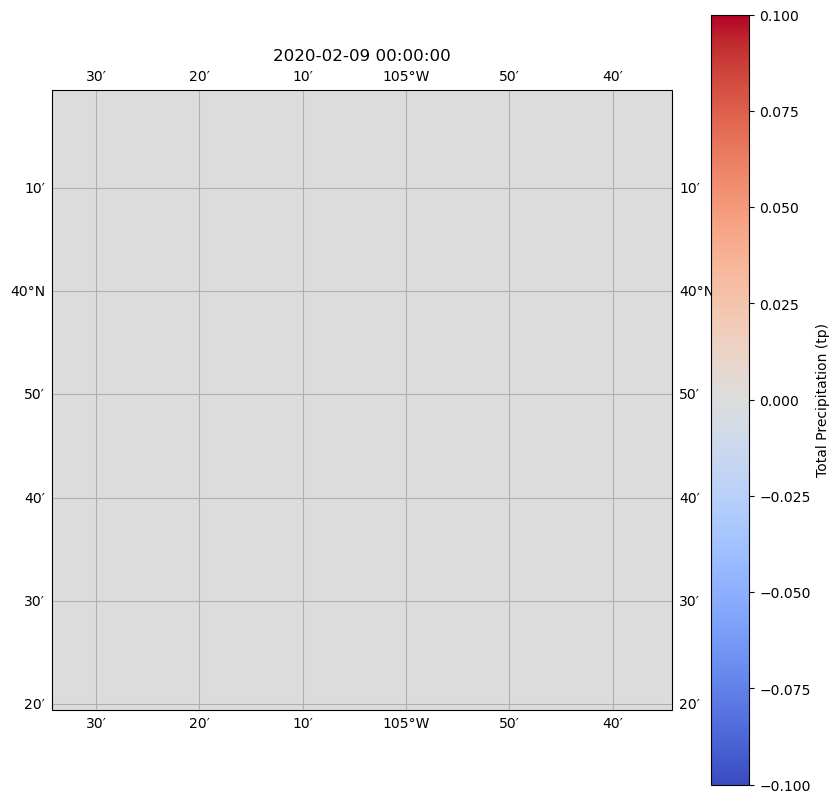

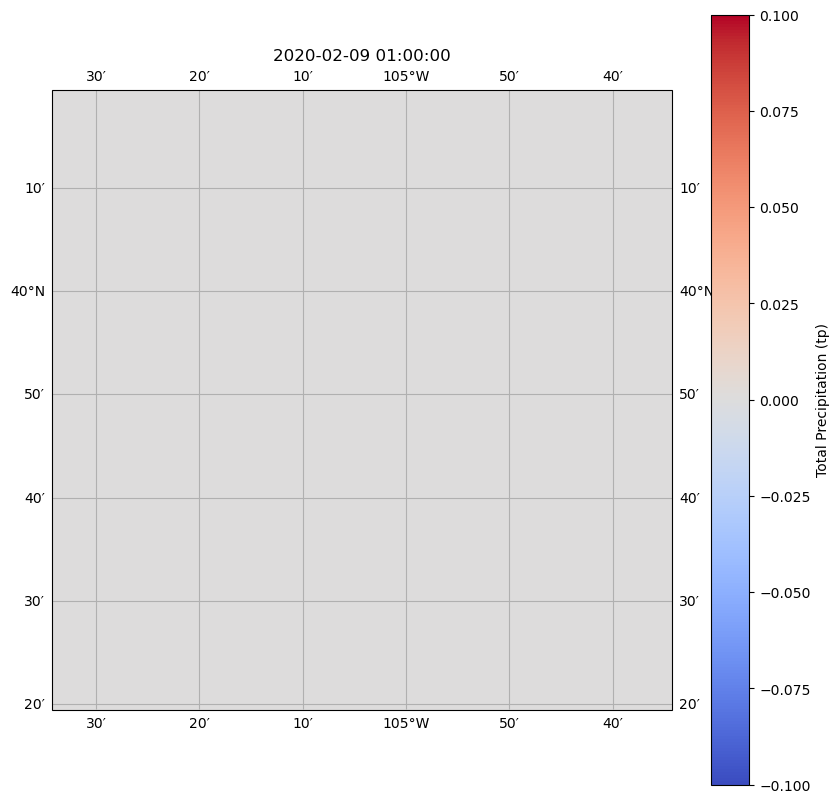

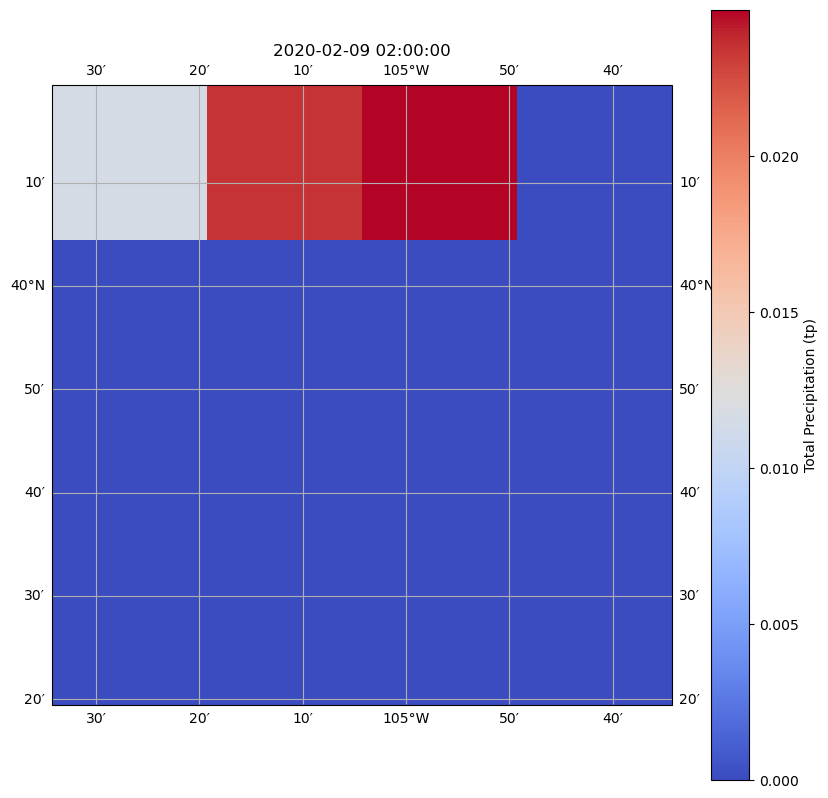

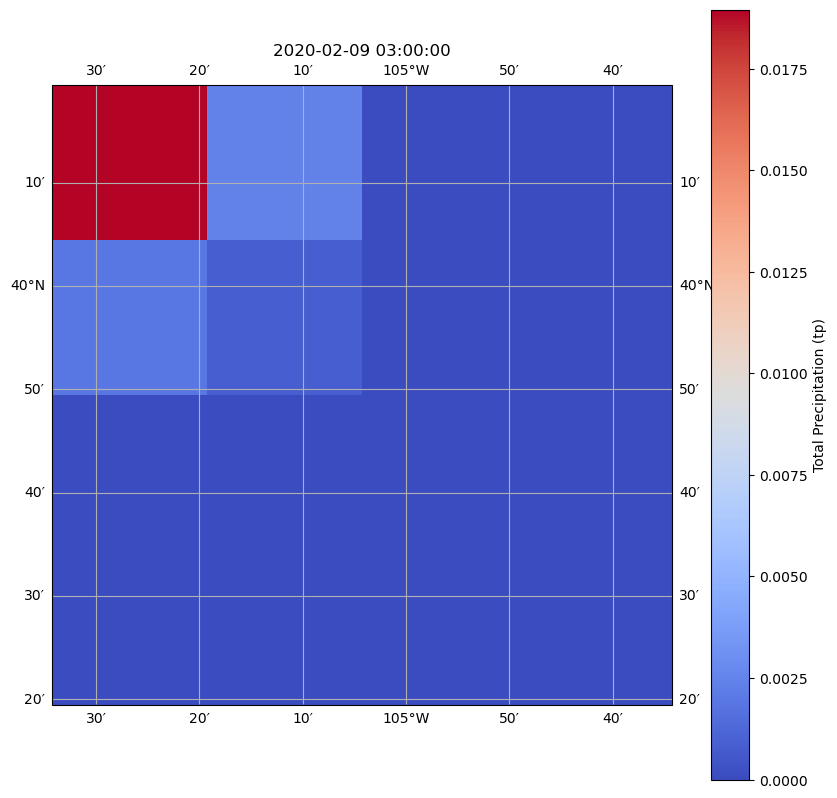

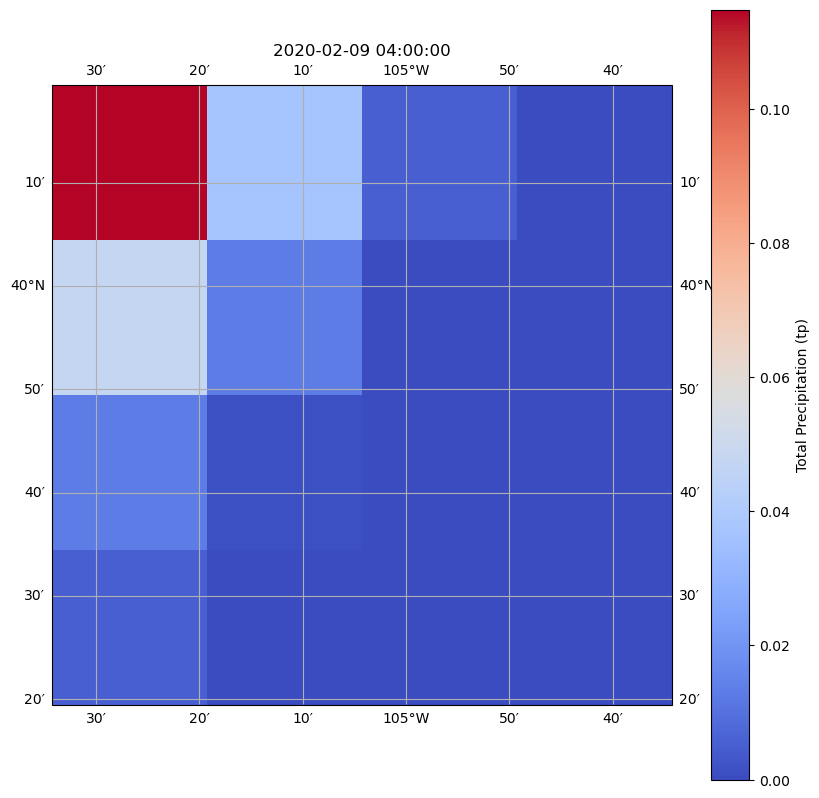

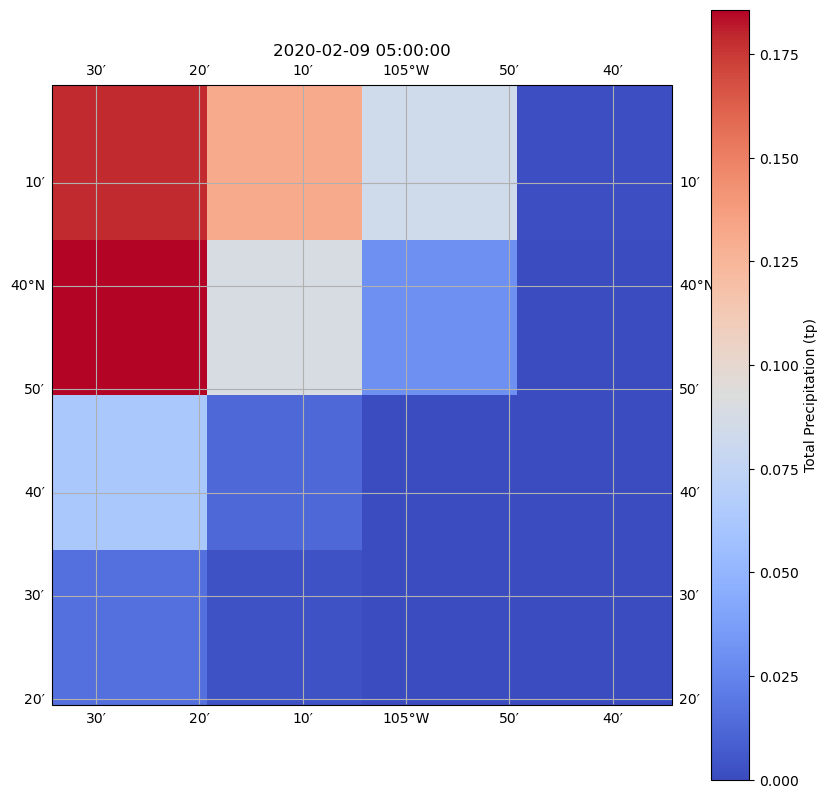

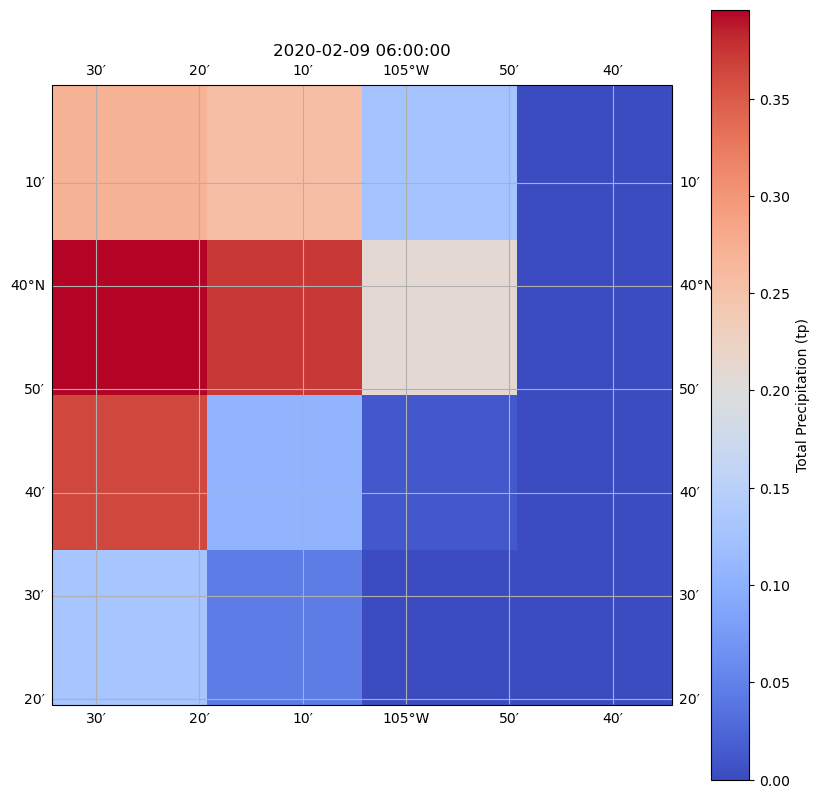

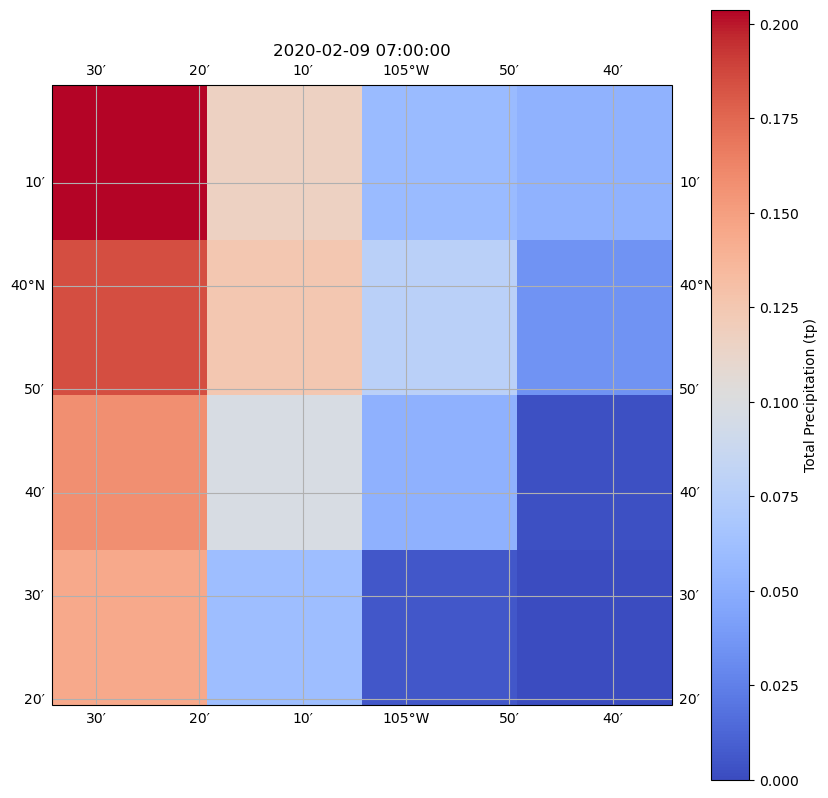

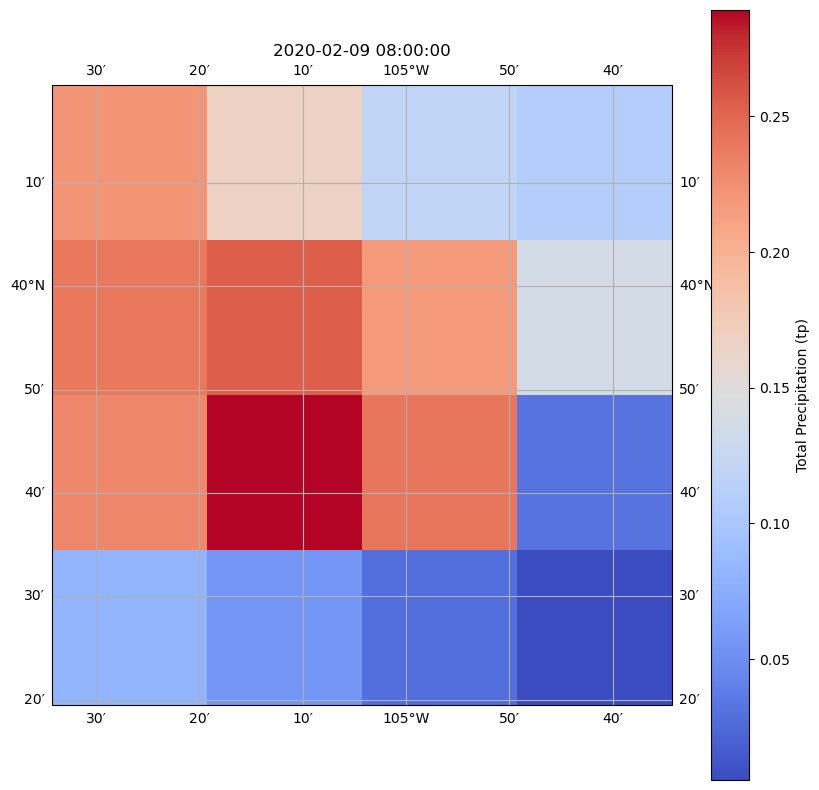

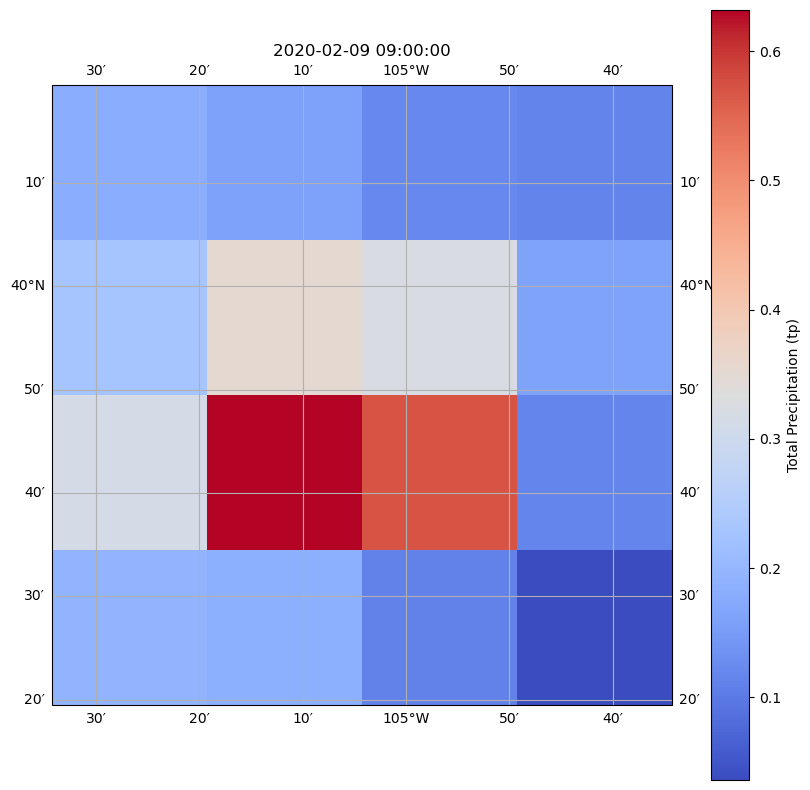

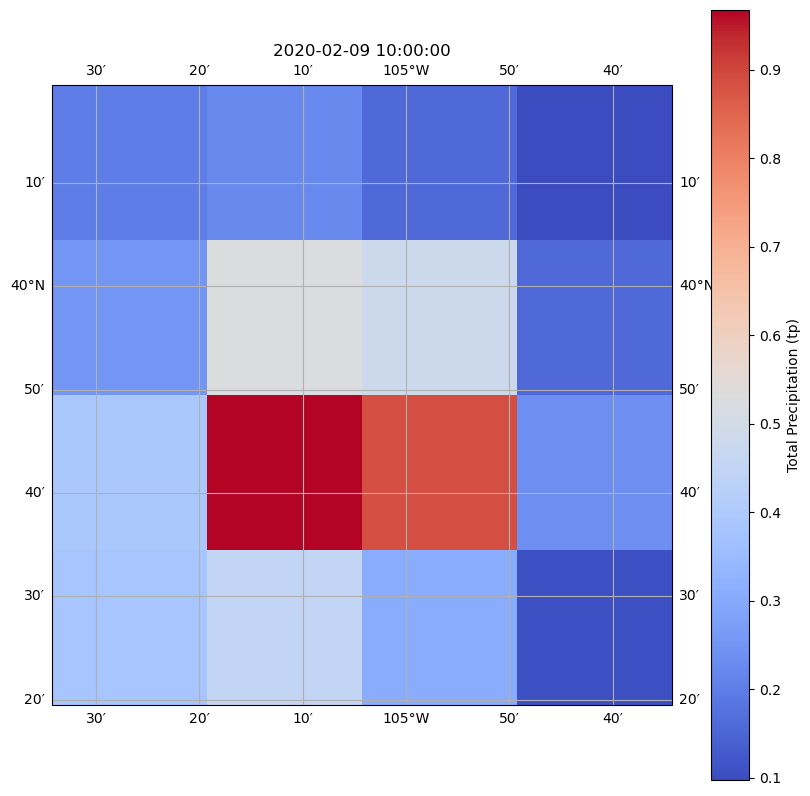

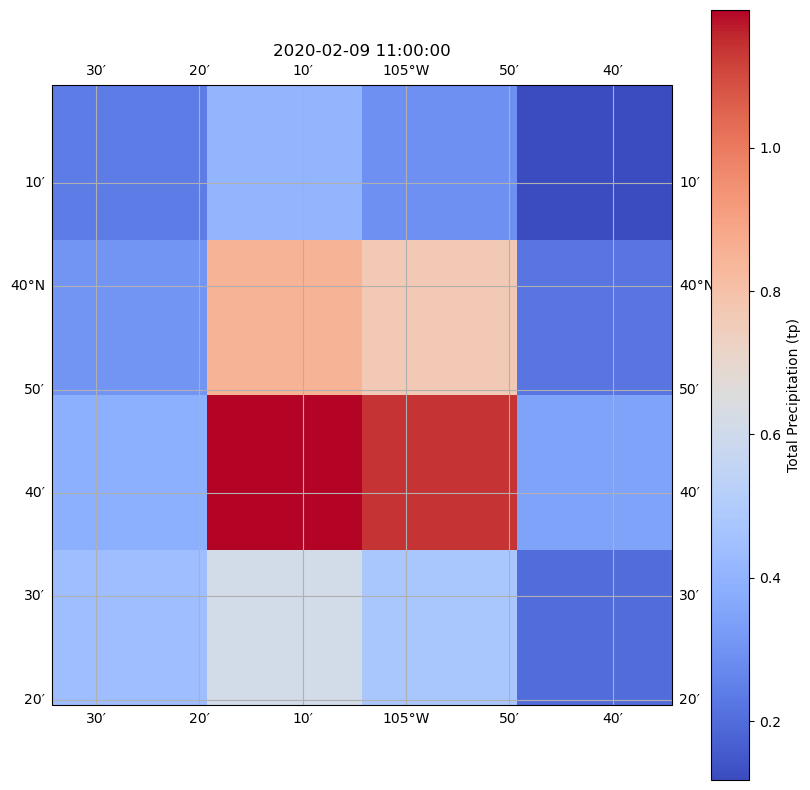

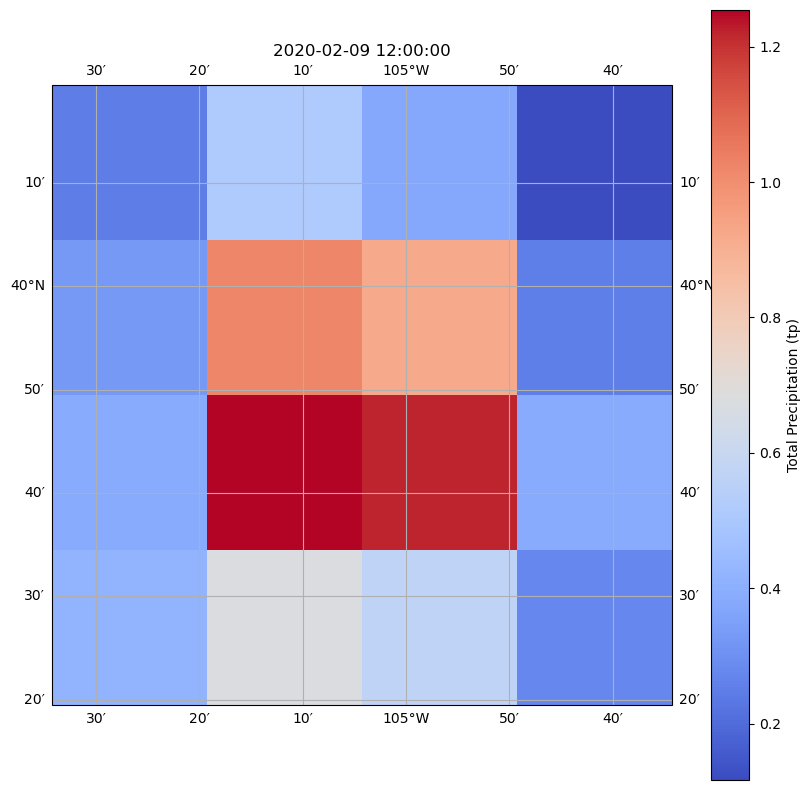

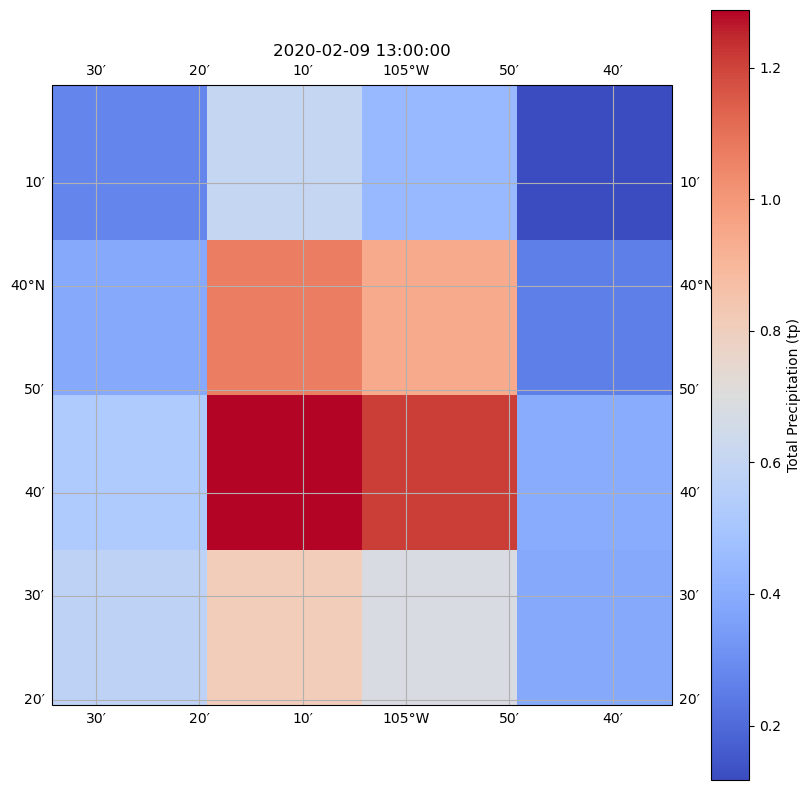

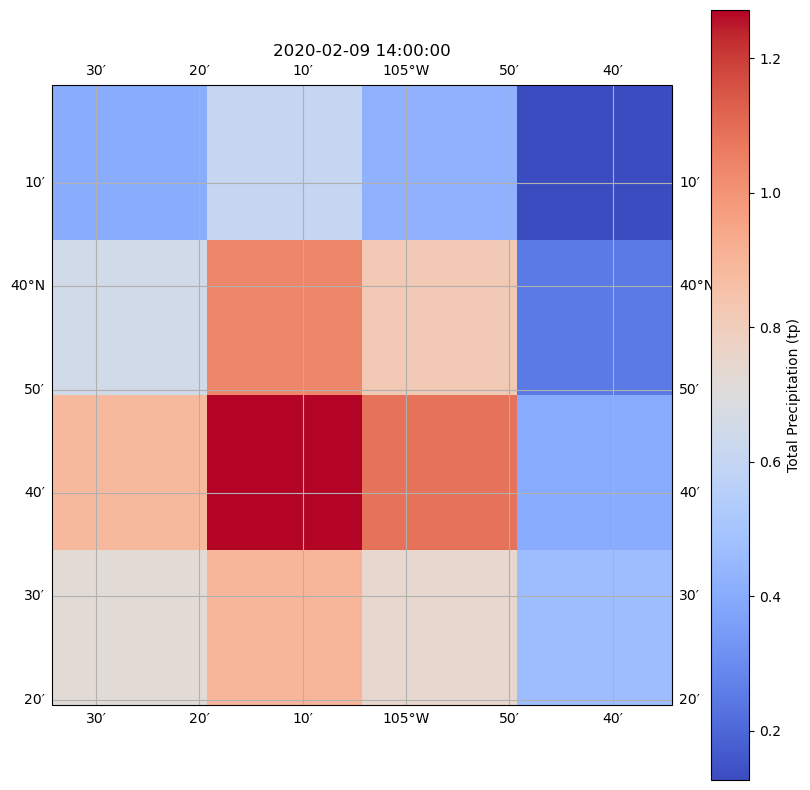

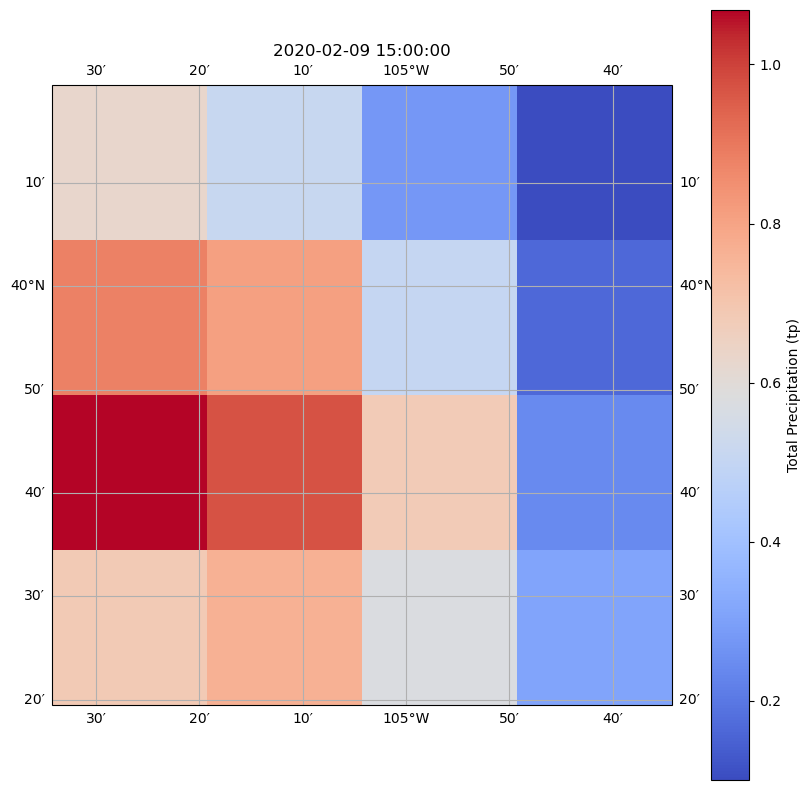

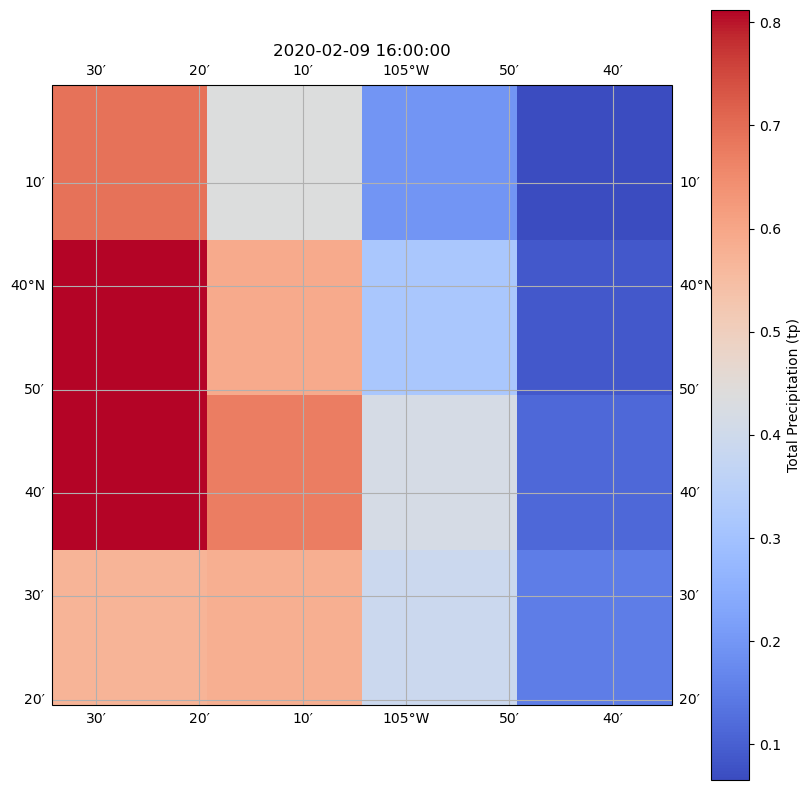

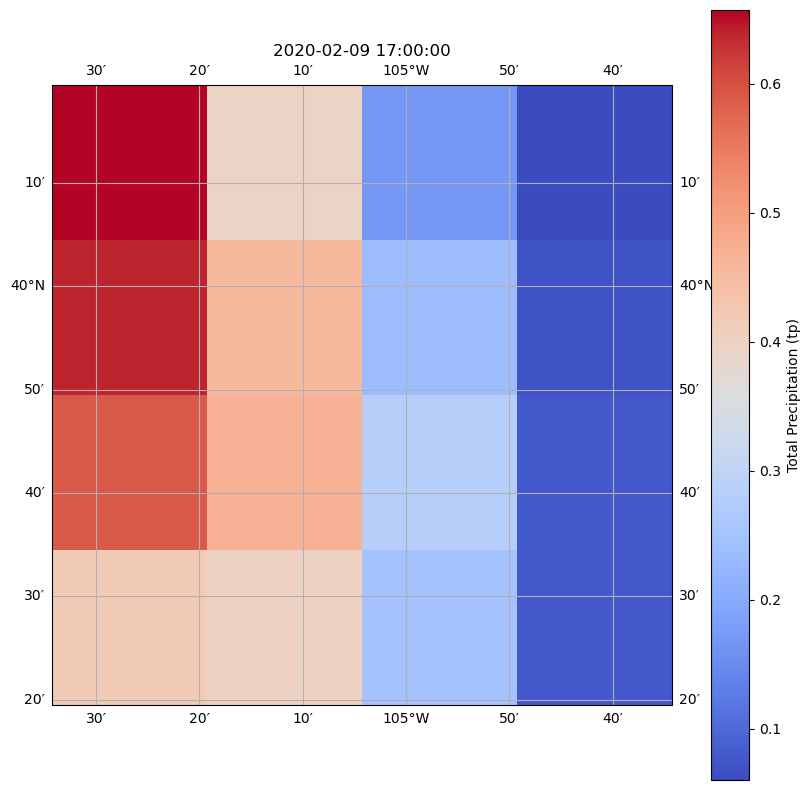

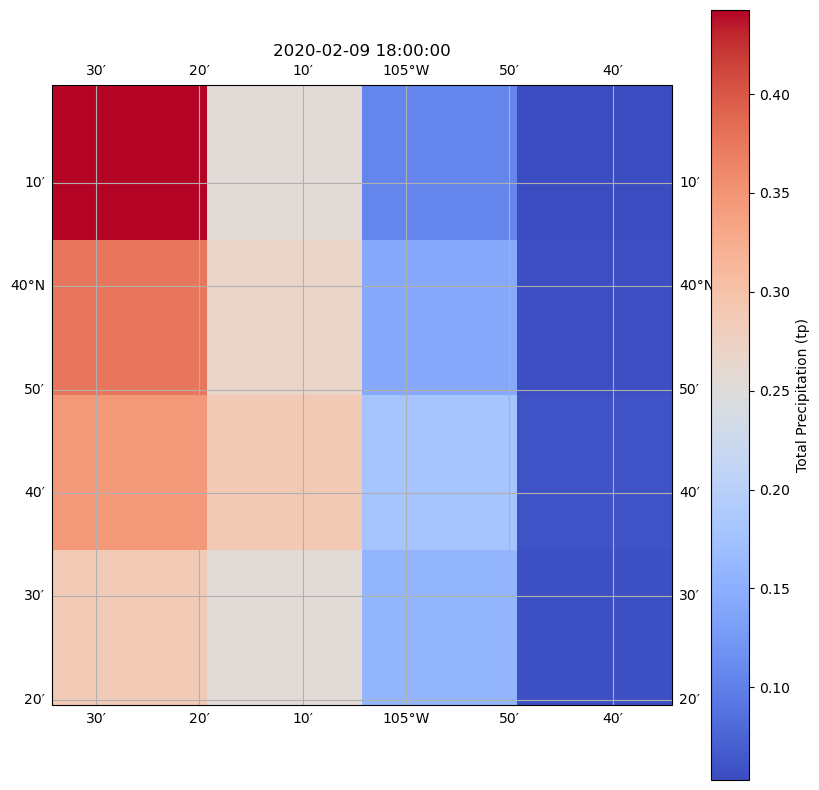

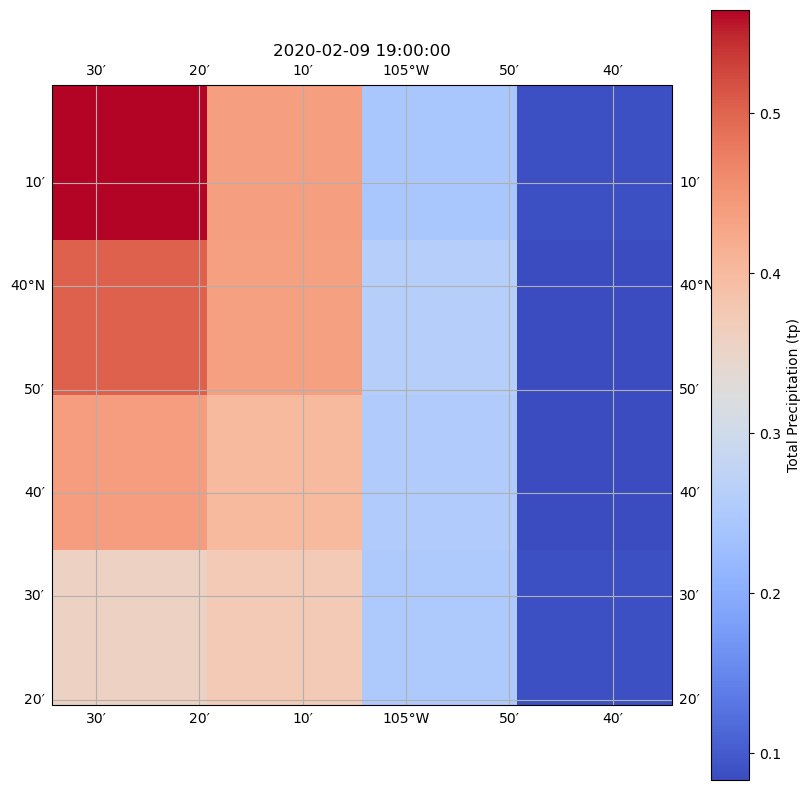

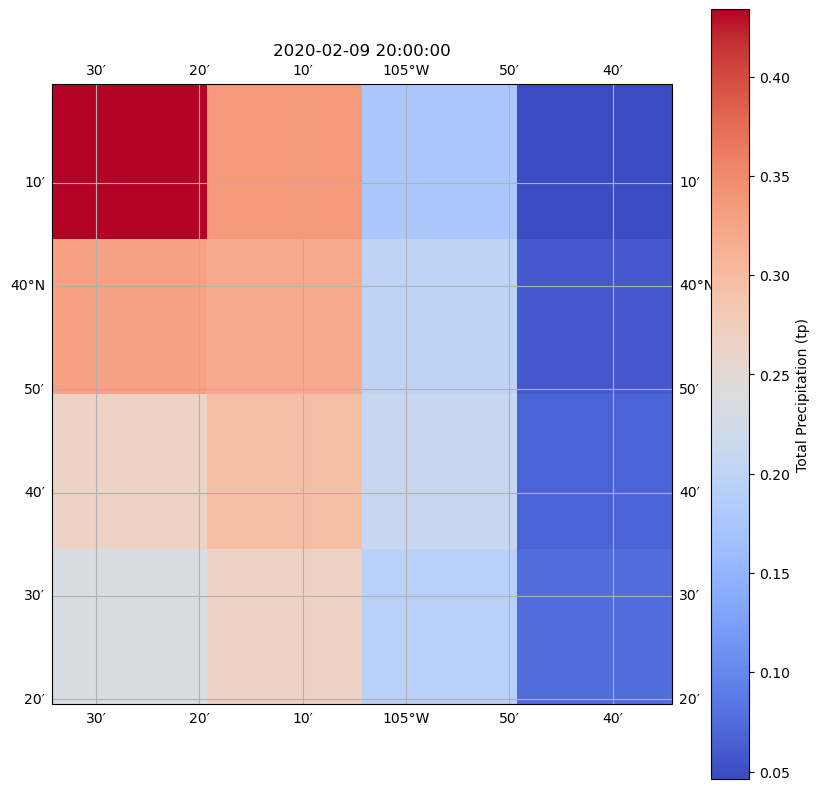

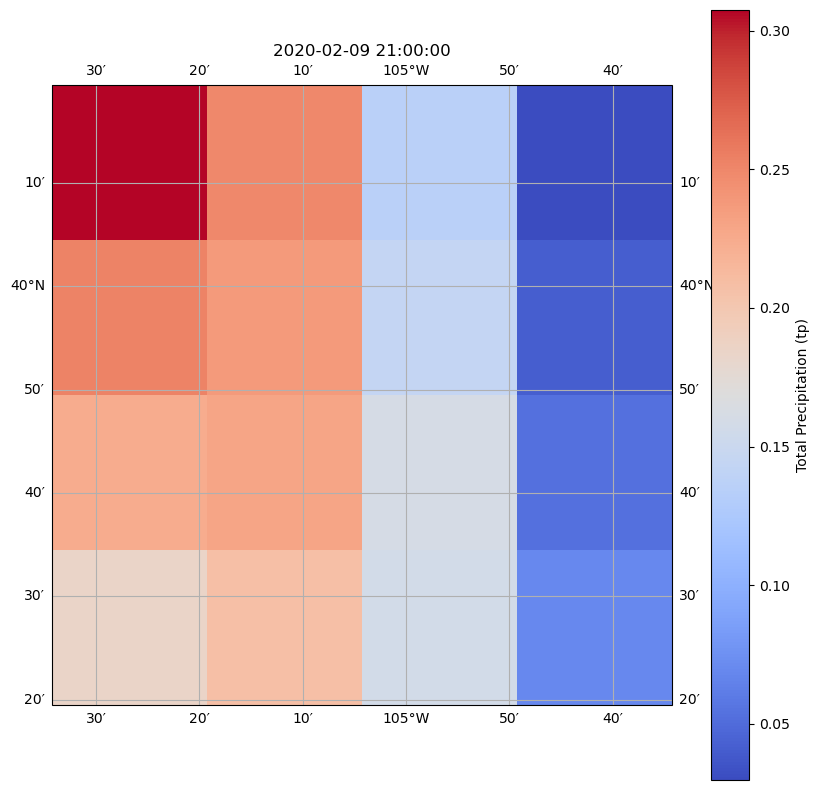

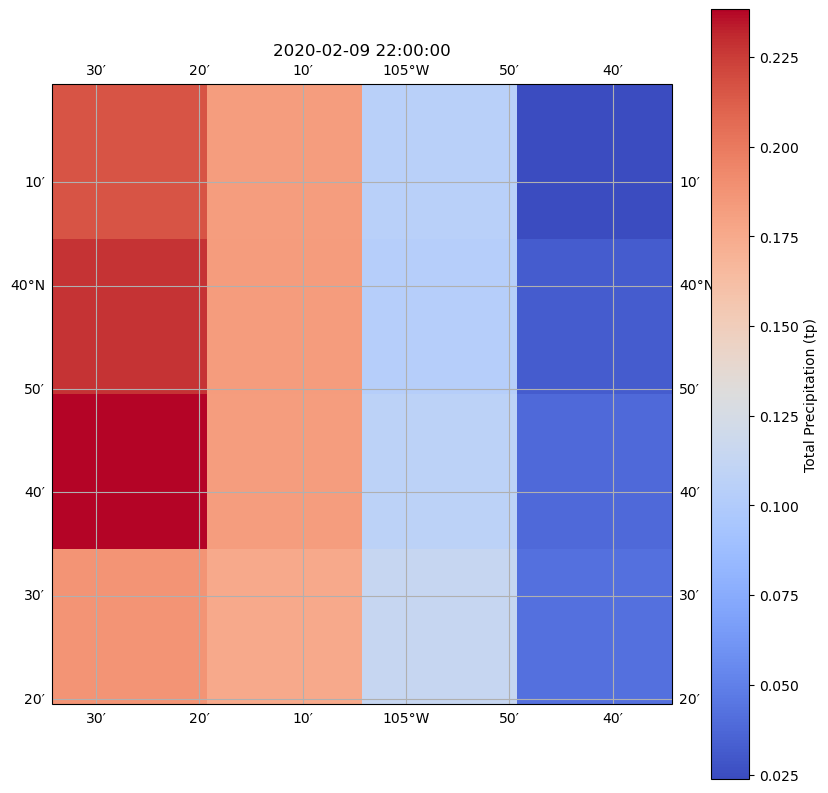

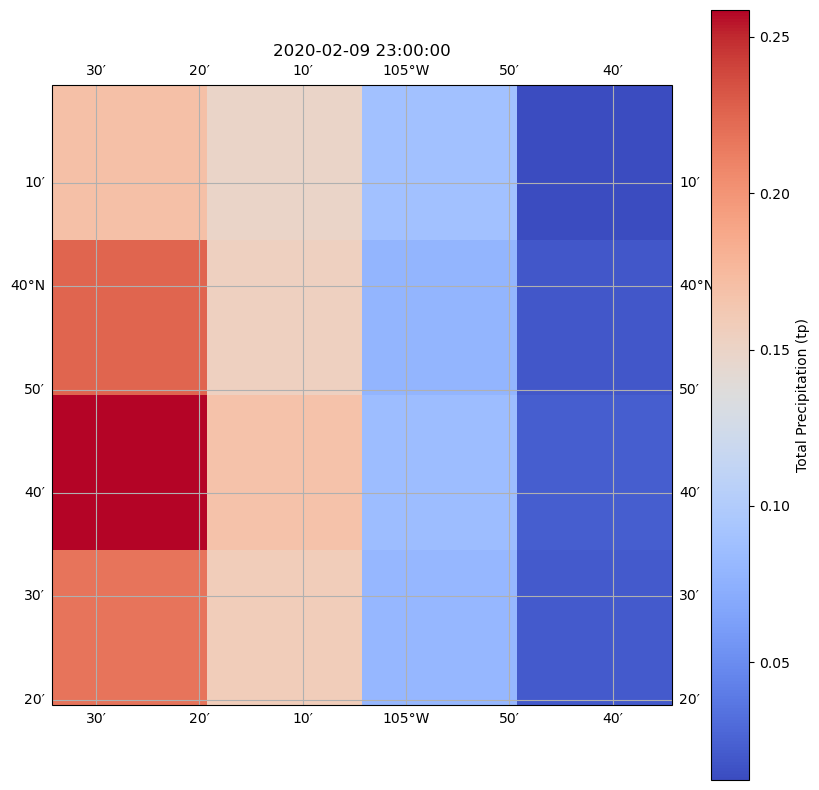

In [74]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assume nc_era5_marshall is your xarray dataset and "tp" is the variable you want to plot.
n = nc_era5_marshall.valid_time.size

for time_index in range(n):
    # Extract the valid time for the current time step and convert it to a readable format
    title = f"\n{nc_era5_marshall.valid_time.values[time_index].astype('datetime64[s]').astype('O')}"

    # Extract the data for the selected variable at the current time step
    data = nc_era5_marshall["tp"].isel(valid_time=time_index).values
    
    # Extract lat/lon values from the dataset (assuming 'latitude' and 'longitude' dimensions)
    lons = nc_era5_marshall['longitude'].values
    lats = nc_era5_marshall['latitude'].values

    # Create the figure and axis with Cartopy projection
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Use pcolormesh to correctly plot the data with geographic coordinates
    mesh = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap='coolwarm')

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, label='Total Precipitation (tp)')

    # Set the title
    ax.set_title(title)

    # Set figure size
    fig.set_size_inches(10, 10)

    # Show the plot
    plt.show()



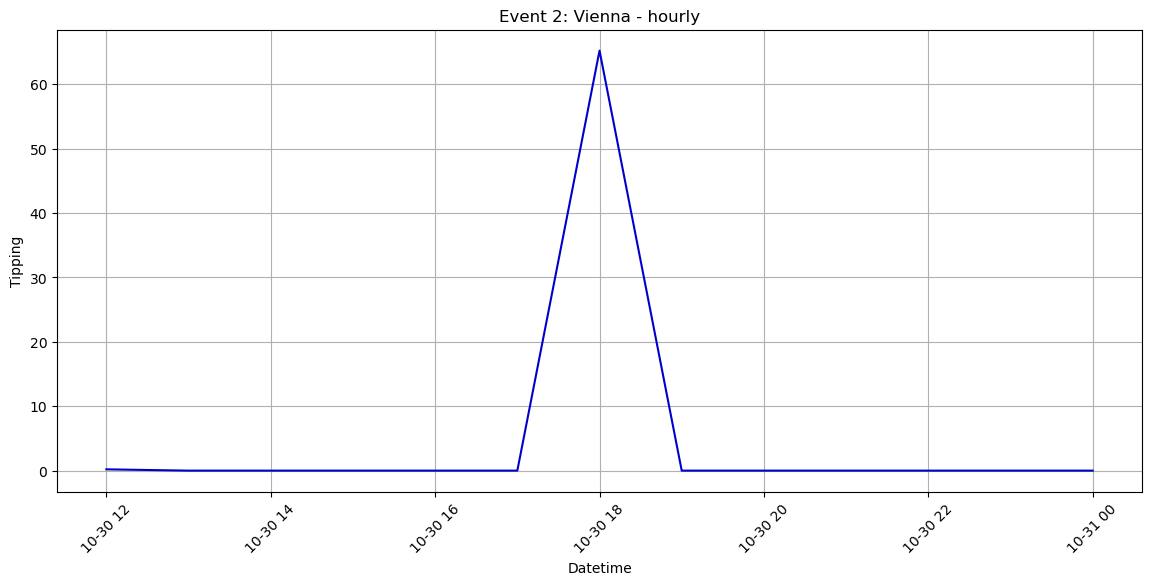

In [151]:
event_2 = pd.Timestamp("2021-10-30 18:00:00")

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df = hourly_df[(hourly_df.index >= event_2 - time_delta) & (hourly_df.index <= event_2 + time_delta)]

plt.figure(figsize=(14,6))
plt.plot(filtered_df["tipping"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("Tipping")
plt.title("Event 2: Vienna - hourly")
plt.xticks(rotation=45)
plt.grid(True)


plt.show()

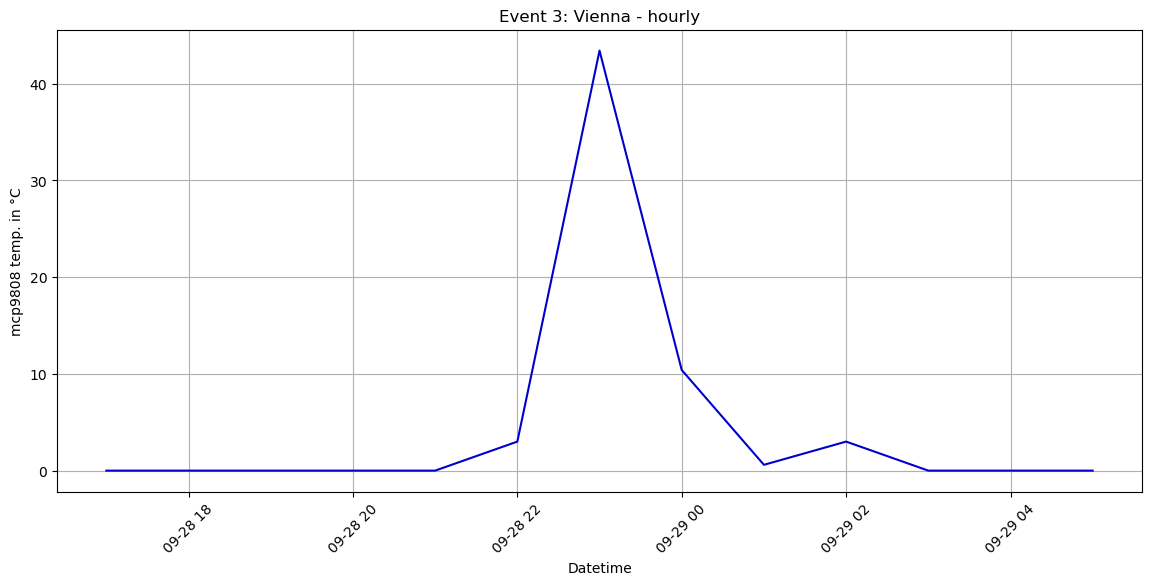

In [152]:
event_3 = pd.Timestamp("2020-09-28 23:00:00")

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df = hourly_df[(hourly_df.index >= event_3 - time_delta) & (hourly_df.index <= event_3 + time_delta)]

plt.figure(figsize=(14,6))
plt.plot(filtered_df["tipping"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("mcp9808 temp. in °C")
plt.title("Event 3: Vienna - hourly")
plt.xticks(rotation=45)
plt.grid(True)


plt.show()